In [8]:
import math
import orjson
import os

import numpy as np

class BenchResult:
    def __init__(self,run, filename):
        self.run = run
        self.alg = filename.split(".")[0].split("_")[0]
        self.size = int(filename.split(".")[0].split("_")[-2])
        self.lang = filename.split(".")[0].split('_')[-1]
        self.kind = "_".join(filename.split("_")[1:-2]) if len(filename.split("_")) > 2 else None
        self.isreference = False
        if self.kind == "native" or self.kind == "naive" :
            self.kind = None
        self.empty = False

        self._data = orjson.loads(open(run + "/" + filename, "r").read())

        # times = sorted(self._data['times'])  # in nanoseconds
        # if len of times is higher than 10, remove the first and last 10% of times
        # if len(times) > 10:
        #     to_remove = len(times) // 10
        #     times = times[to_remove:-to_remove]

        # make times a numpy array
        times = np.array(self._data["times"])
        self._data.pop("times")

        if len(times) == 0:
            self.empty = True
            print(f"warning: no samples found for {filename}")
            return

        times.sort()
        # from times remove top and bottom log2 of the times
        # if len(times) > 100:
        #     to_remove = math.ceil(math.log2(len(times)))
        #     times = times[to_remove:-to_remove]

        self.mean = times.mean()
        self.std = times.std()
        self.median = np.median(times)

        # get a data sample for every 0.1% percentile, including min and max
        if len(times) > 1000:
            self.samples = np.array([times[int(i * len(times) / 1000)] for i in range(1000)])
        else:
            if self.lang != "mojo":
                print(f"warning: only {len(times)} samples found for {filename}")
            self.samples = times

        print(f"loaded {filename} - {self.mean} ± {self.std} ({self.alg}-{self.size}, {self.lang}, {self.kind})")

    def __str__(self):
        return f"{self.alg} ({self.lang})"

    @property
    def mean_secs(self):
        return self.mean / 1e9

    @property
    def ident(self):
        if self.kind:
            return f"{self.alg}-{self.size}_{self.lang}_{self.kind}"
        else:
            return f"{self.alg}-{self.size}_{self.lang}"

    @property
    def implementation(self):
        if self.kind:
            return f"{self.lang}_{self.kind}"
        else:
            return f"{self.lang}"

    def __lt__(self, other):
        if self.alg != other.alg:
            return self.alg < other.alg
        if self.size != other.size:
            return int(self.size) < int(other.size)
        if self.lang != other.lang:
            return self.lang < other.lang
        if self.kind != other.kind:
            return str(self.kind) < str(other.kind)
        return False


run = "data/full_final_15m_vu"

benches = [BenchResult(run, filename) for filename in os.listdir(run) if filename.endswith(".json")]

loaded softmax_simd_2048_rs.json - 21540.482138343898 ± 3220.030561233684 (softmax-2048, rs, simd)
loaded quicksort_10000_codon.json - 13929936.07470864 ± 182298.84547284615 (quicksort-10000, codon, )
loaded softmax_simd_proper_8192_mojo.json - 29259.807265558804 ± 16.533615698164333 (softmax-8192, mojo, simd_proper)
loaded softmax_native_128_rs.json - 1405.6403356766718 ± 5597.092793756257 (softmax-128, rs, None)
loaded softmax_native_512_rs.json - 5550.822369015575 ± 2793.237176388832 (softmax-512, rs, None)
loaded matmul_np_512_pypy.json - 12971191.3995417 ± 6625009.971641946 (matmul-512, pypy, np)
loaded quicksort_100000_pypy.json - 53007758119.166664 ± 117292734.67301612 (quicksort-100000, pypy, )
loaded softmax_2048_mojo.json - 26486.937605064166 ± 282.11381725296087 (softmax-2048, mojo, )
loaded matmul_2048_mojo.json - 79296022939.33333 ± 0.0 (matmul-2048, mojo, )
loaded crc16_100000_rs.json - 1369264.3781555947 ± 8259.314949970894 (crc16-100000, rs, )
loaded crc16_naive_1000000

In [9]:
benches = [b for b in benches if not b.empty]

benches.sort()


algs = set(b.alg for b in benches)

# for each alg+size, find the bench with lang py, if multiple prefer one with np in kind, otherwise empty kind
for alg in algs:
    for size in set([b.size for b in benches if b.alg == alg]):
        py_bench = [
            b for b in benches if b.alg == alg and b.size == size and b.lang == "py"
        ]
        if len(py_bench) == 0:
            raise ValueError(f"no py bench for {alg}-{size}")
        if len(py_bench) == 1:
            py_bench[0].isreference = True
            continue
        np_bench = [b for b in py_bench if b.kind == "np"]
        if len(np_bench) == 1:
            np_bench[0].isreference = True
            continue
        py_bench[0].isreference = True
        
language_colors = {
    "mojo": "blue",
    "rs": "red",
    "py": "green",
    "pypy": "yellow",
    "codon": "purple",
}

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


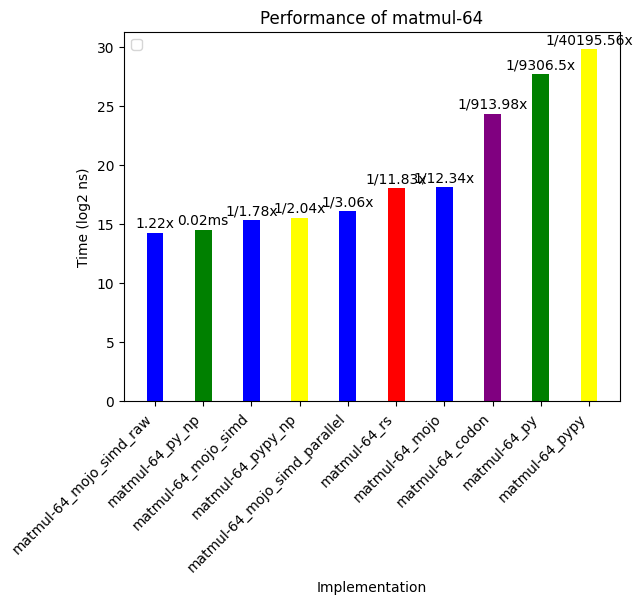

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


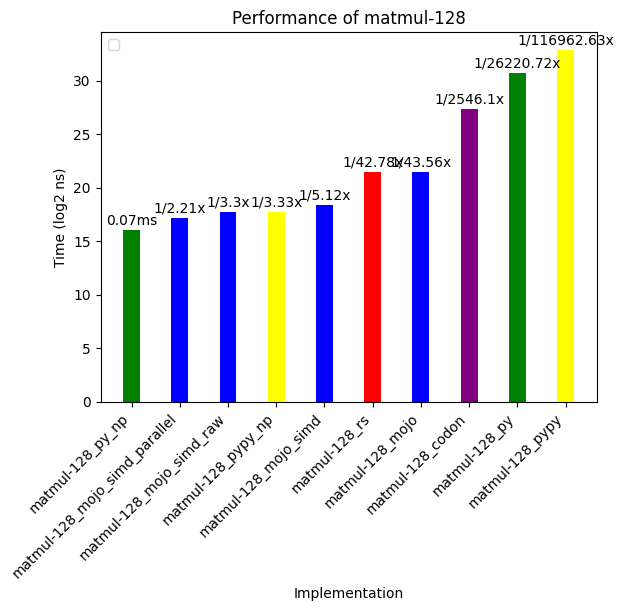

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


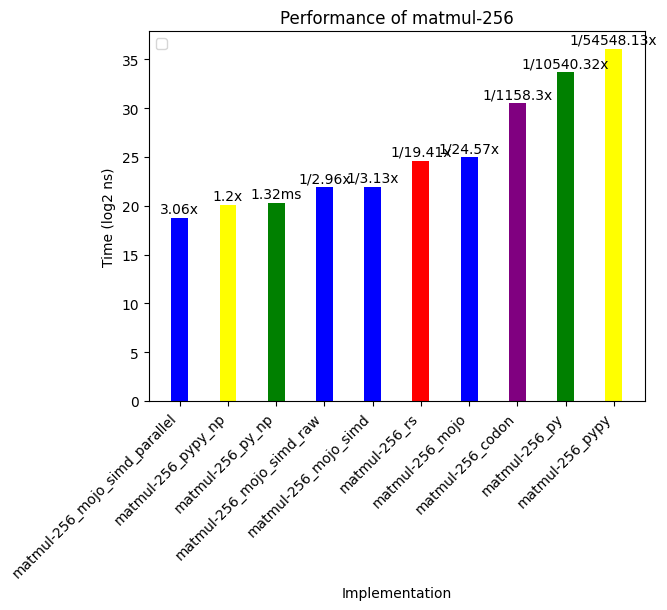

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


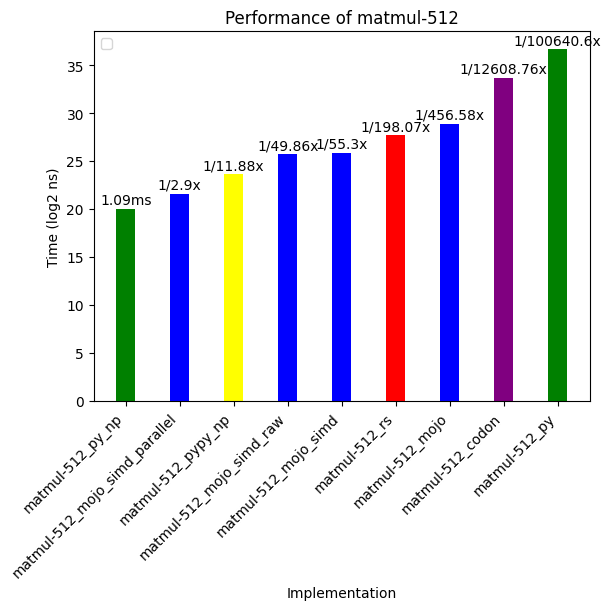

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


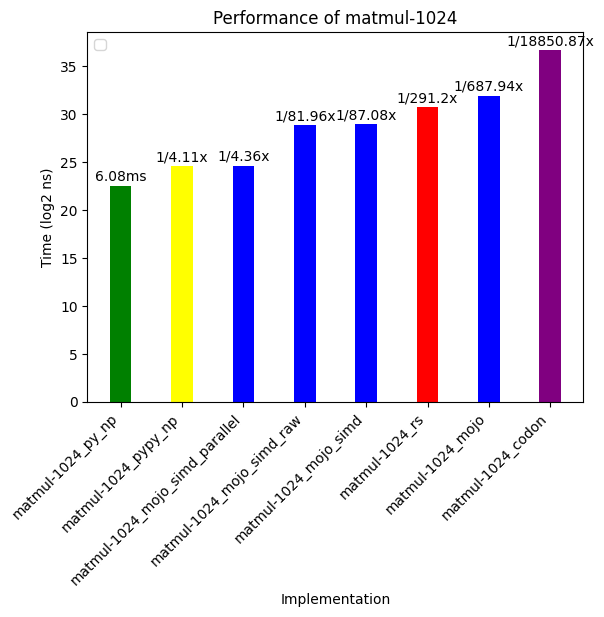

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


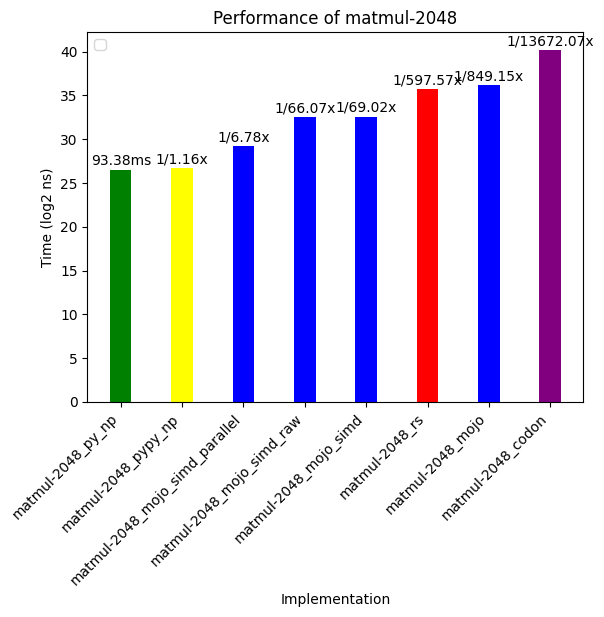

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


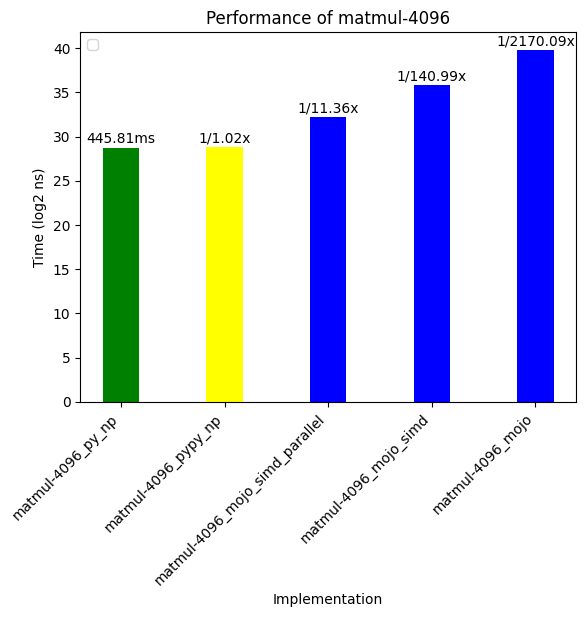

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


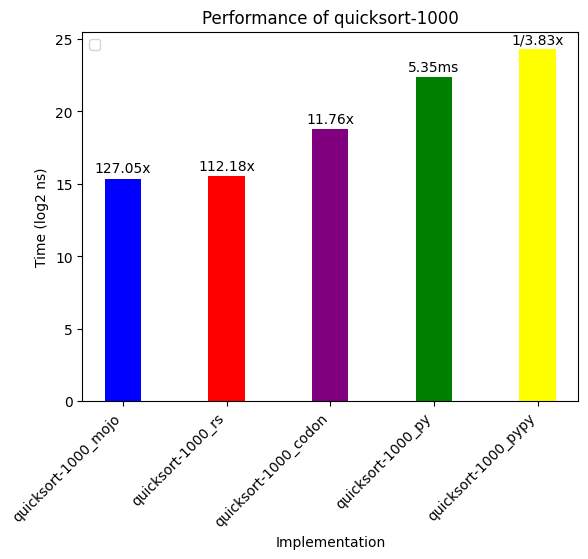

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


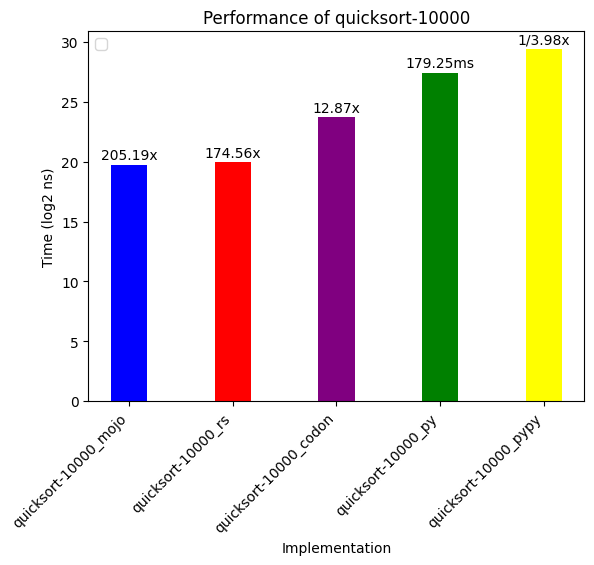

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


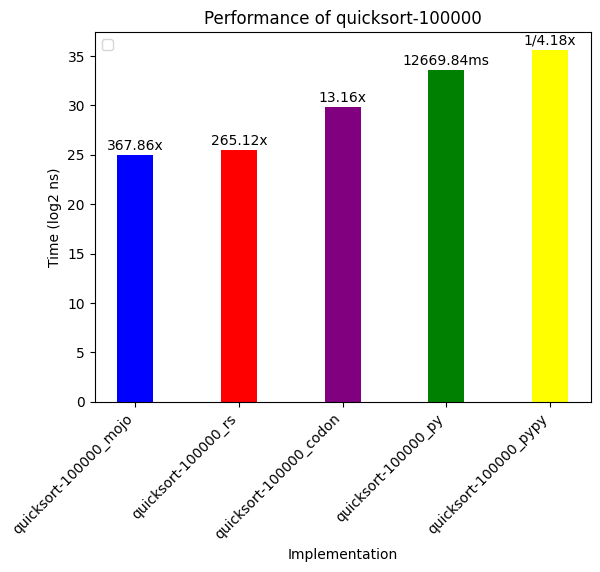

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


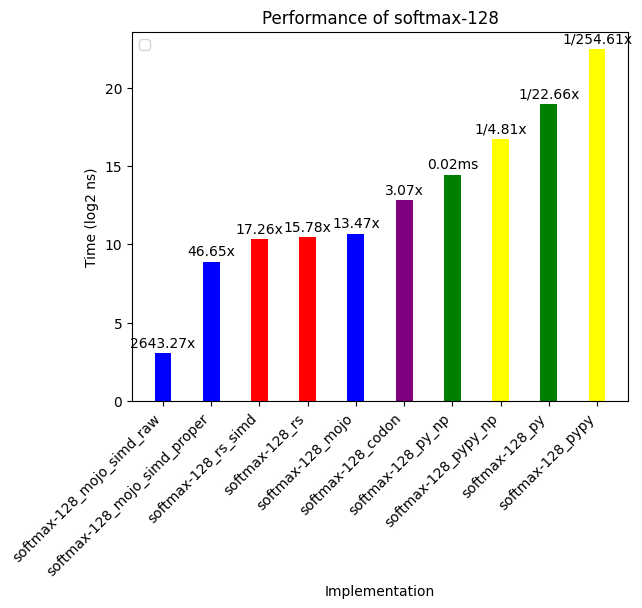

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


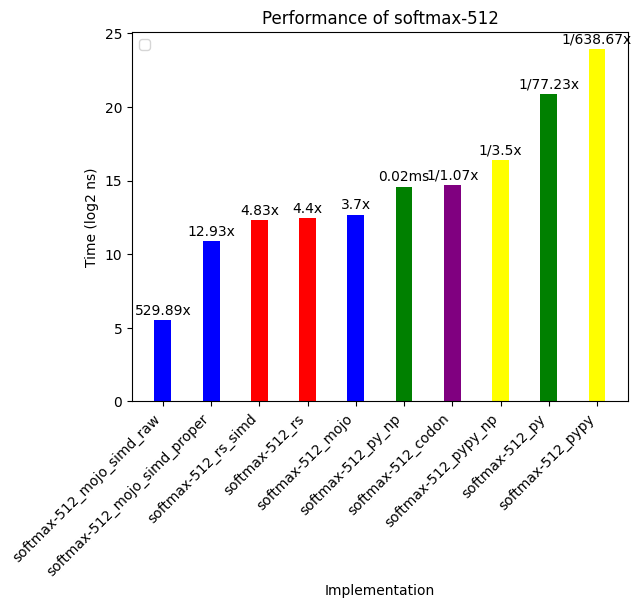

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


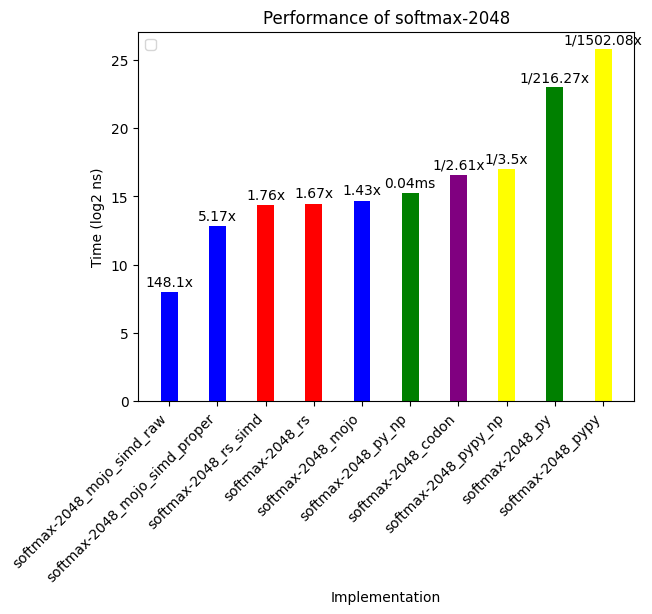

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


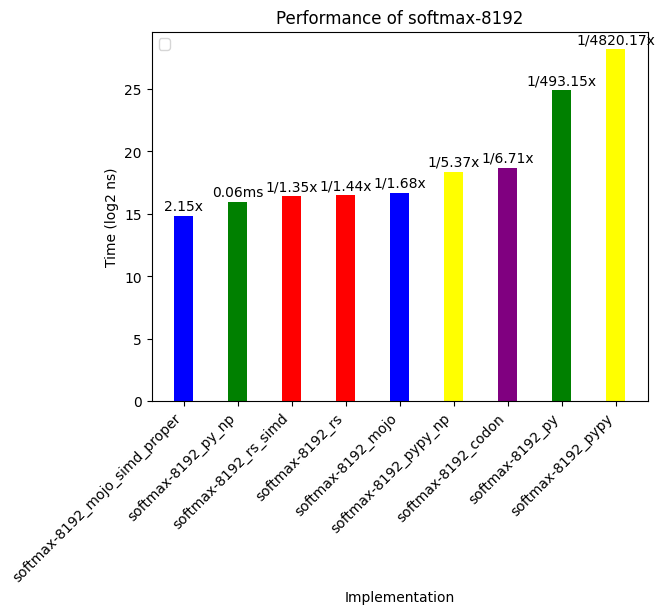

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


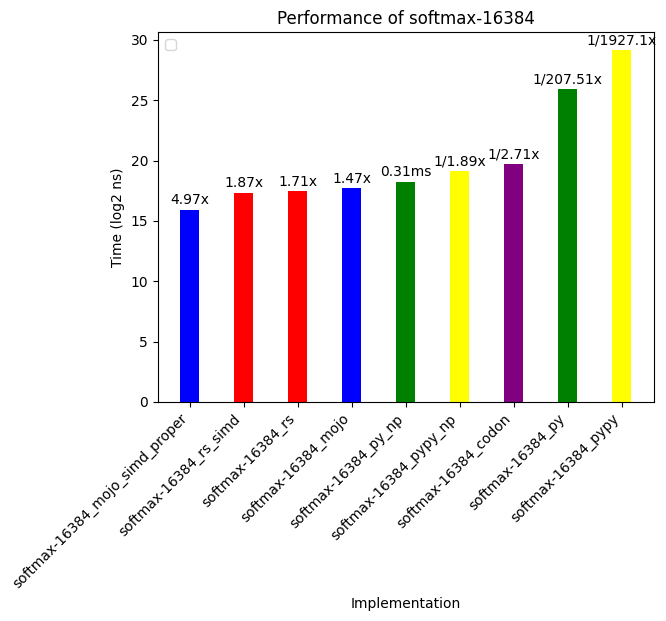

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


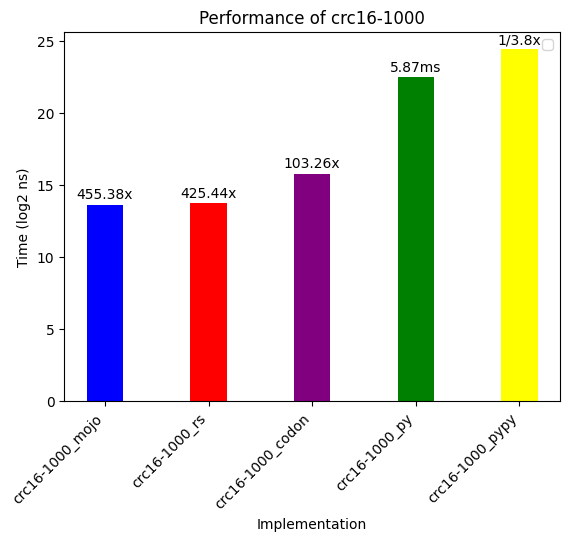

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


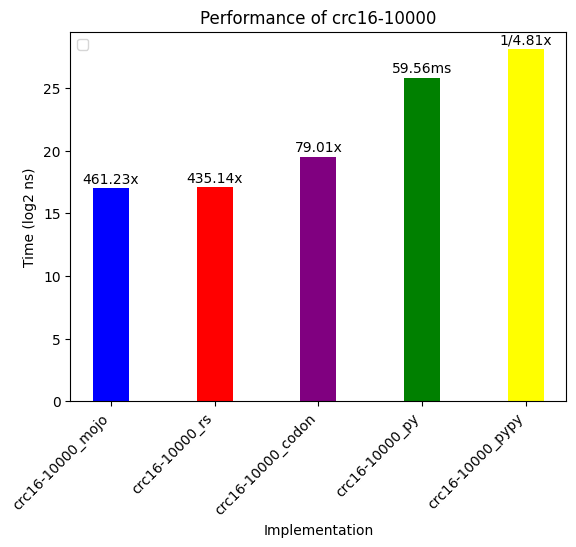

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


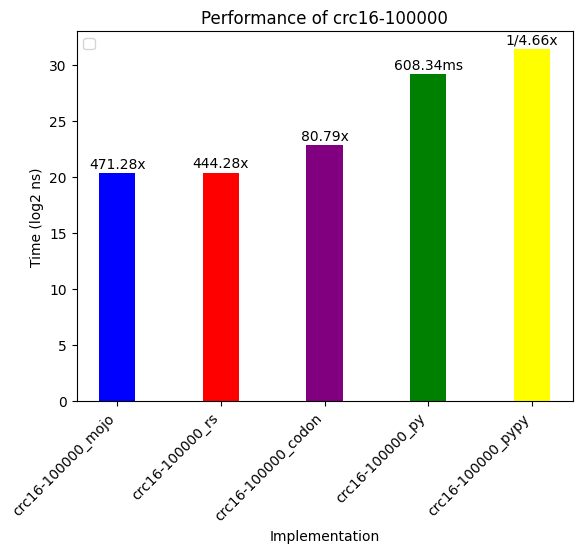

/tmp/ipykernel_11933/2802334799.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


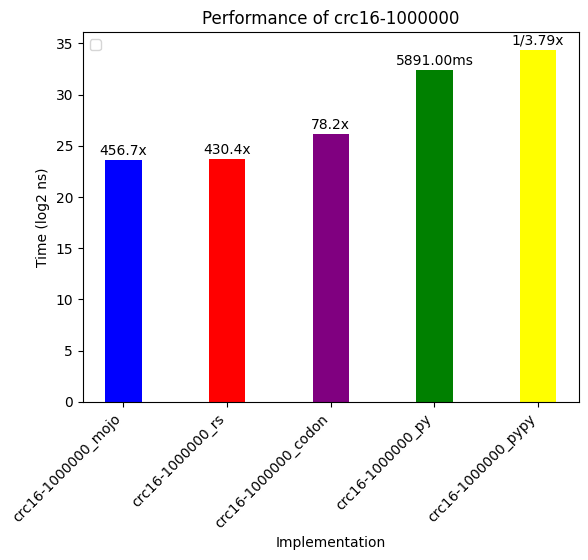

In [10]:
import math
import matplotlib.pyplot as plt
import numpy as np

for alg in algs:
    plt.figure()  # Create a new figure for each algorithm
    benches_for_alg = sorted([b for b in benches if b.alg == alg], key=lambda b: b.mean)
    sizes = sorted(set(b.size for b in benches_for_alg), key=lambda s: int(s))
    for size in sizes:
        benches_for_size = [b for b in benches_for_alg if b.size == size]
        reference = [b.mean for b in benches_for_size if b.isreference][0]
        bar_width = 0.35
        index = np.arange(len(benches_for_size))

        mean_values = [math.log2(bench.mean) for bench in benches_for_size]
        labels = [f"{bench.ident}" for bench in benches_for_size]
        colors = [language_colors[bench.lang] for bench in benches_for_size]

        bars = plt.bar(index, mean_values, bar_width, color=colors)

        for bar, bench in zip(bars, benches_for_size):
            if bench.isreference:
                content = f"{bench.mean/1e6:.2f}ms"
            else:
                content = (
                    f"1/{round(bench.mean/reference*100)/100}"
                    if bench.mean > reference
                    else f"{round(reference/bench.mean*100)/100}"
                )
                content = str(content) + "x"

            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.2,
                content,
                ha="center",
                va="bottom",
            )

        plt.title(f"Performance of {alg}-{size}")
        plt.xlabel("Implementation")
        plt.ylabel("Time (log2 ns)")
        plt.xticks(index, labels, rotation=45, ha="right")
        plt.legend()
        plt.show()

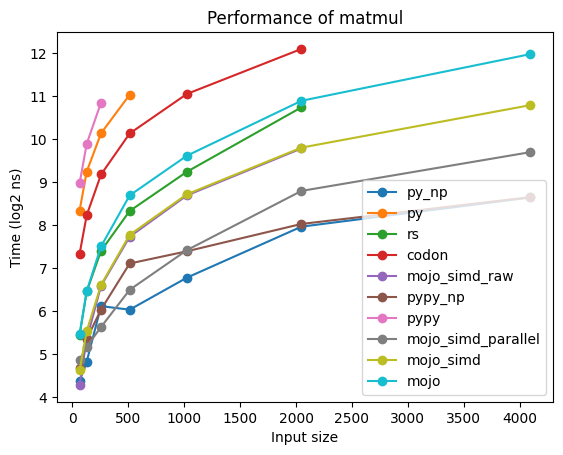

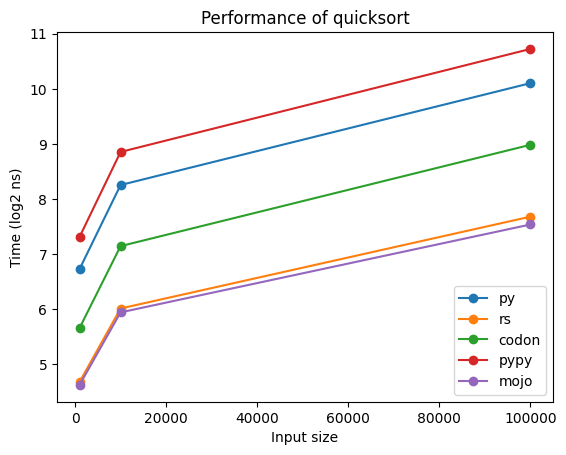

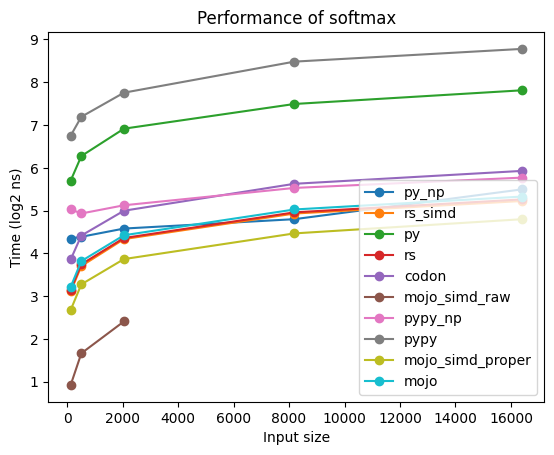

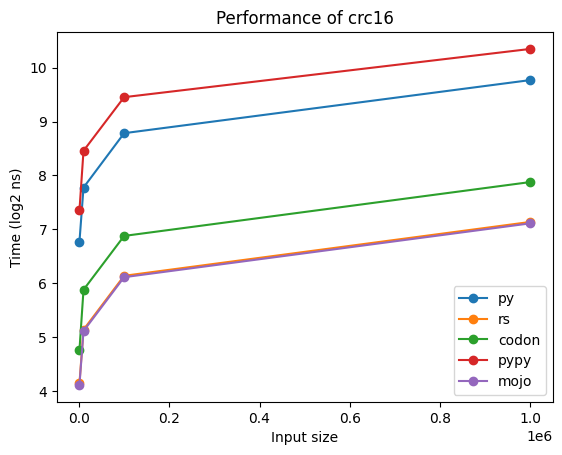

In [11]:
# now we plot benchmark times on a line chart as they scale with input size

for alg in algs:
    plt.figure()  # Create a new figure for each algorithm
    benches_for_alg: list[BenchResult] = sorted([b for b in benches if b.alg == alg], key=lambda b: b.size)
    sizes = sorted(set(b.size for b in benches_for_alg), key=lambda s: int(s))
    impls = set(b.implementation for b in benches_for_alg)
    for impl in impls:
        # get, sorted by size
        benches_for_impl = sorted([b for b in benches_for_alg if b.implementation == impl], key=lambda b: b.size)
        # we draw these where X is size, Y is mean time, connected by lines
        x = [b.size for b in benches_for_impl]
        y = [math.log10(b.mean) for b in benches_for_impl]
        # display small squares on data points
        plt.plot(x, y, label=impl, marker='o')
    plt.title(f"Performance of {alg}")
    plt.xlabel("Input size")
    plt.ylabel("Time (log2 ns)")
    plt.legend()
    plt.show()

                


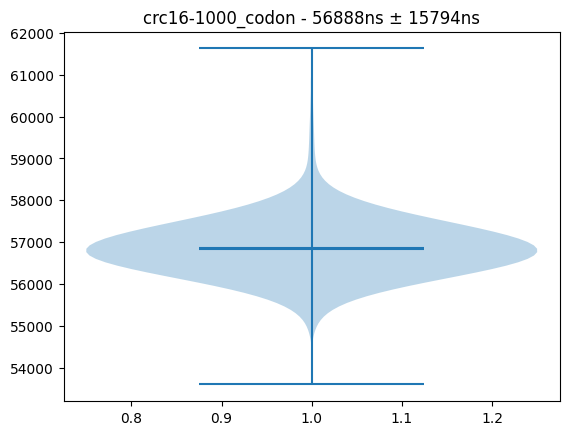

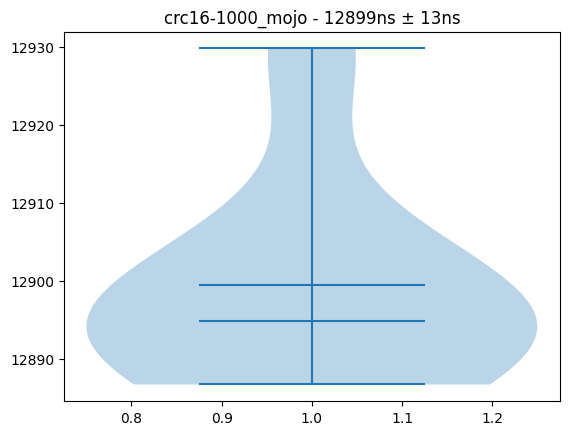

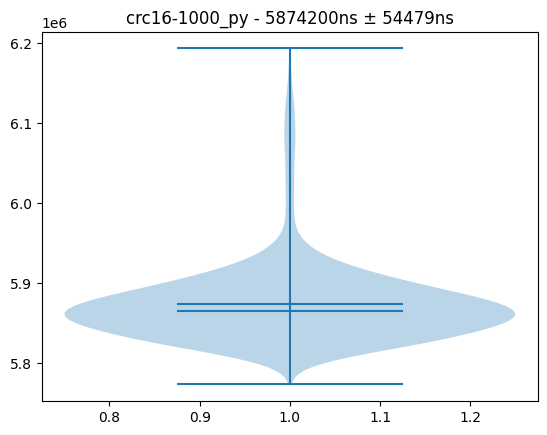

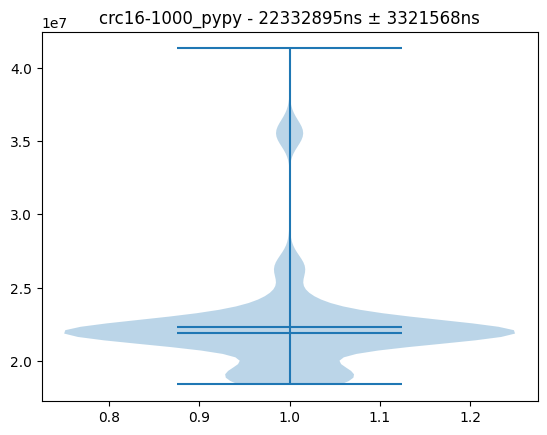

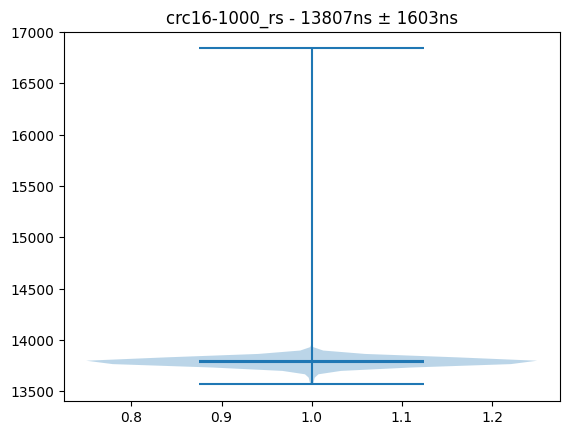

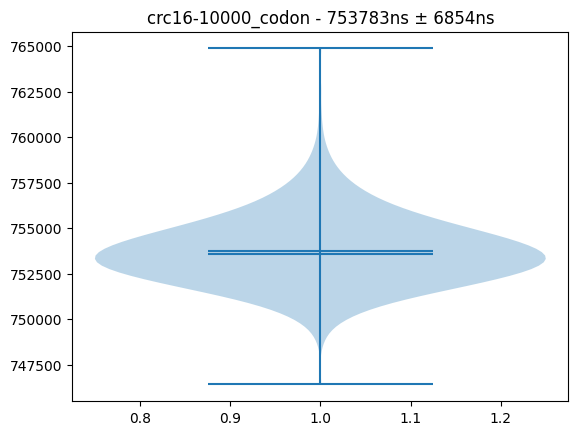

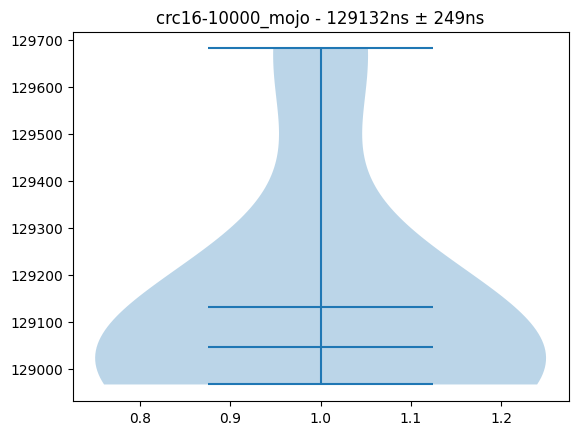

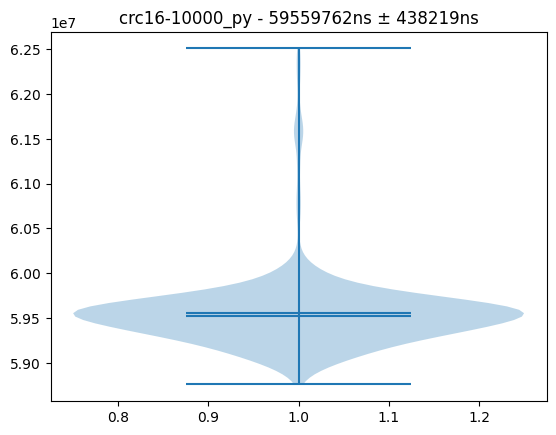

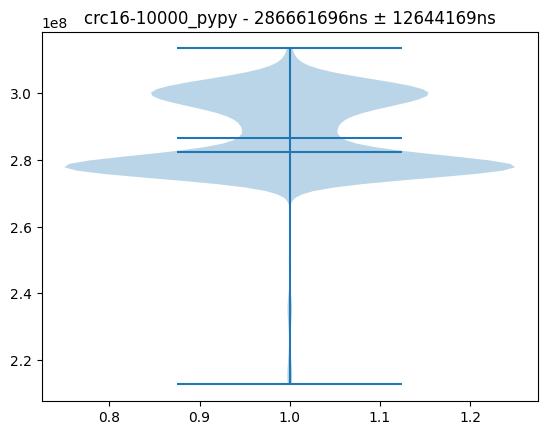

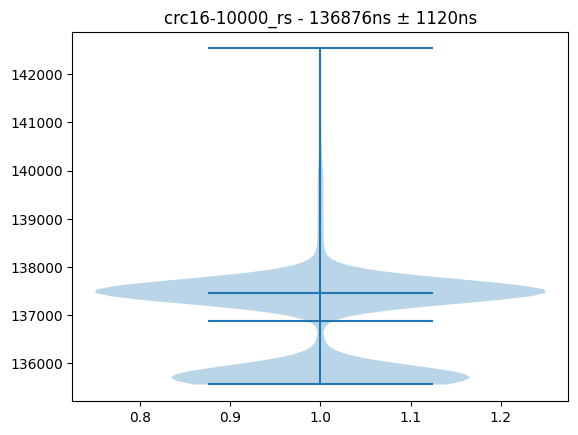

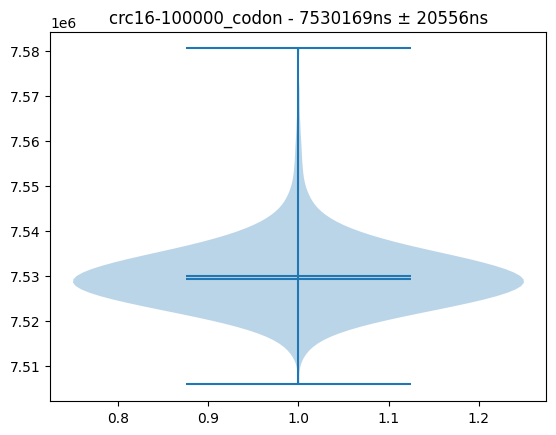

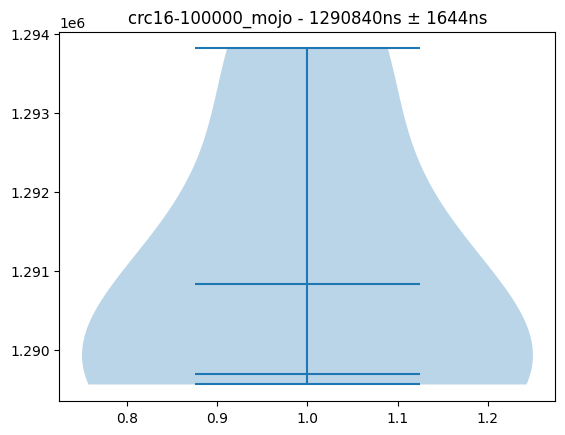

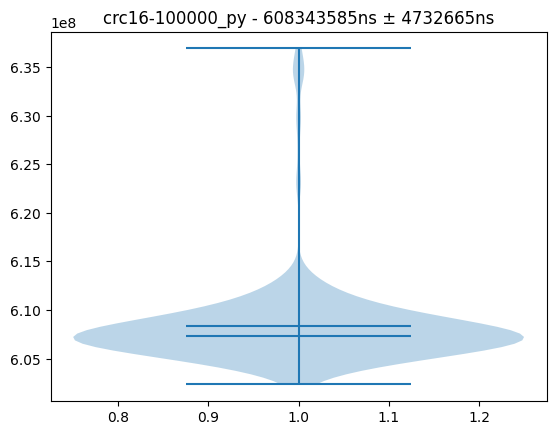

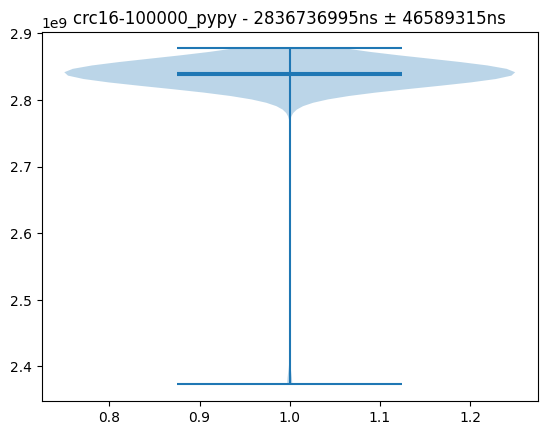

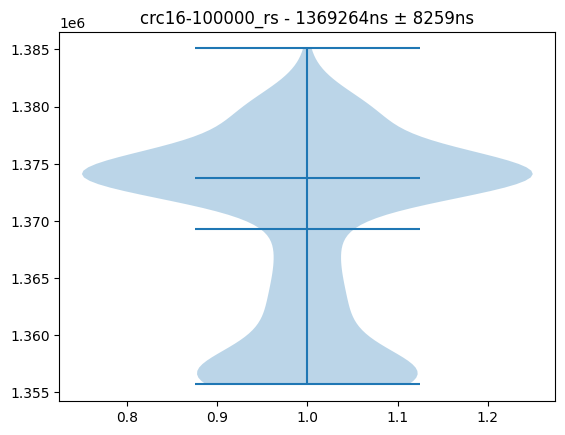

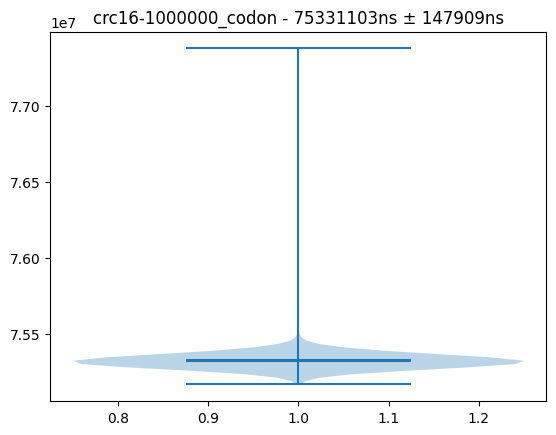

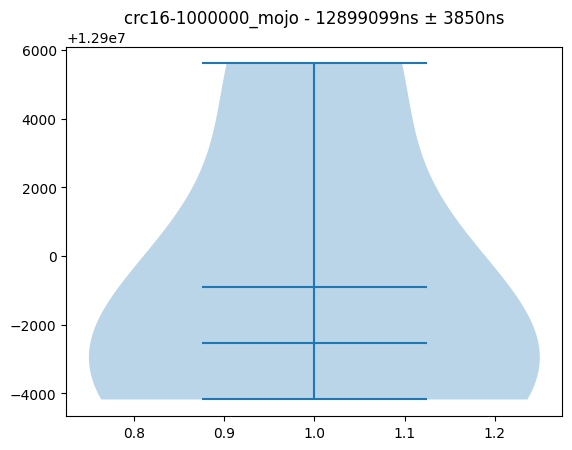

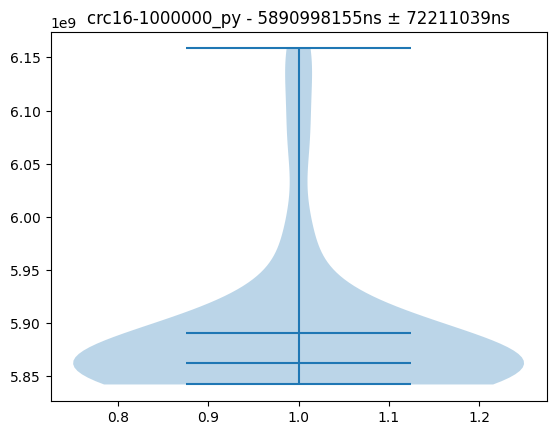

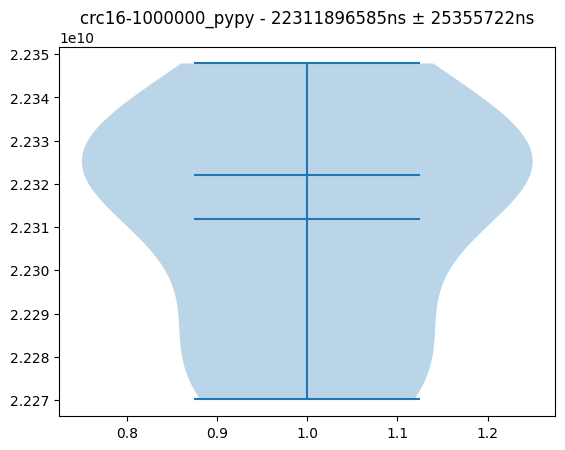

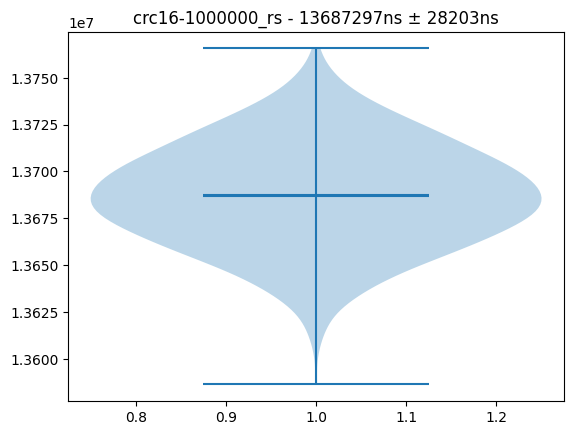

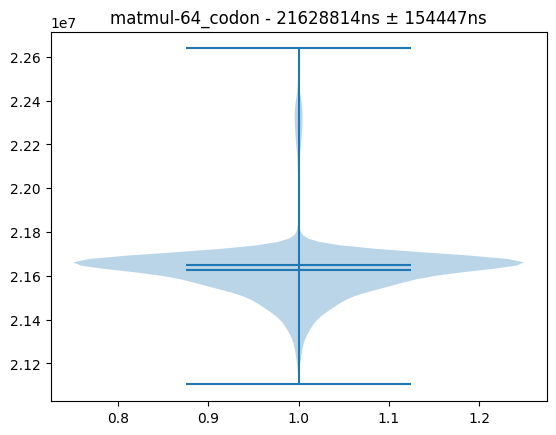

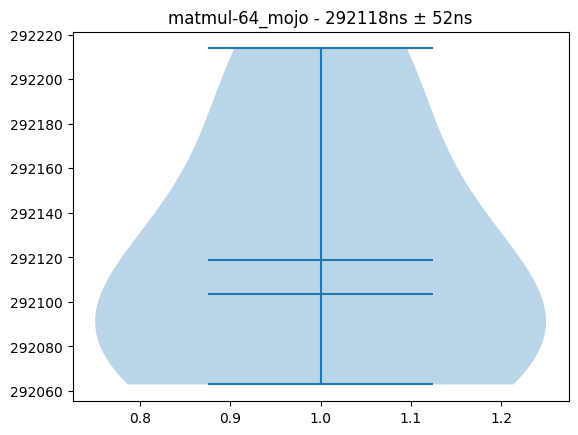

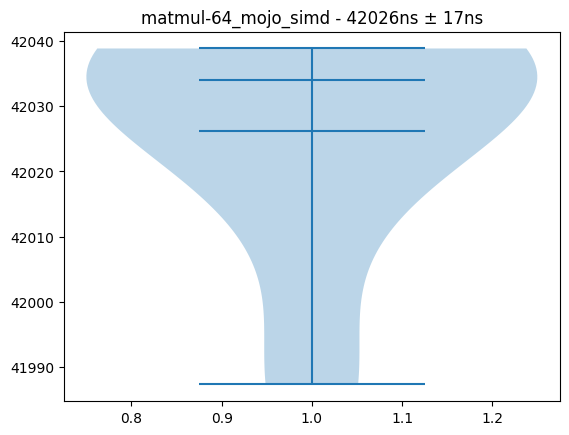

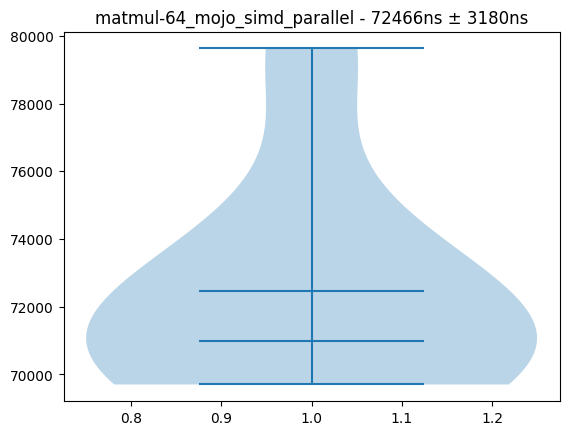

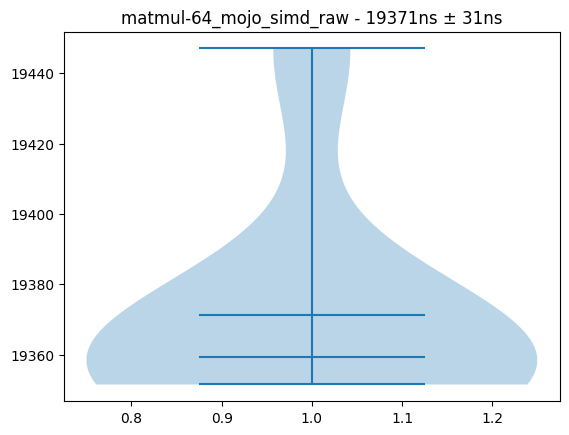

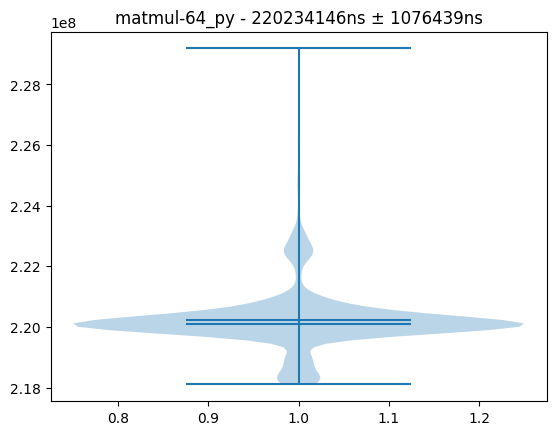

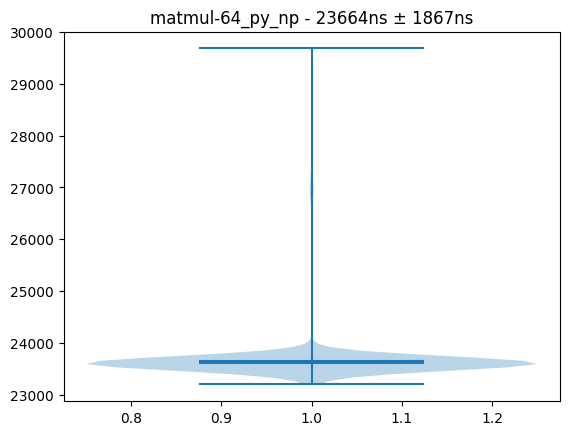

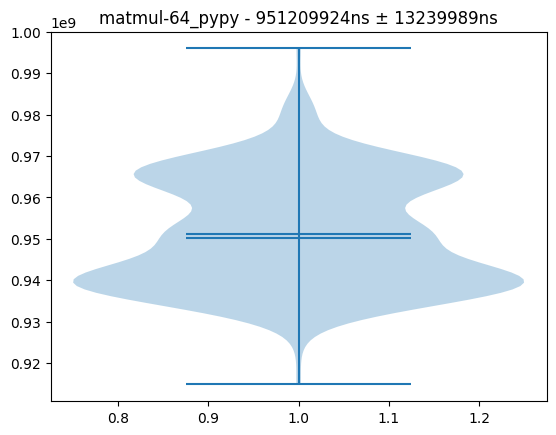

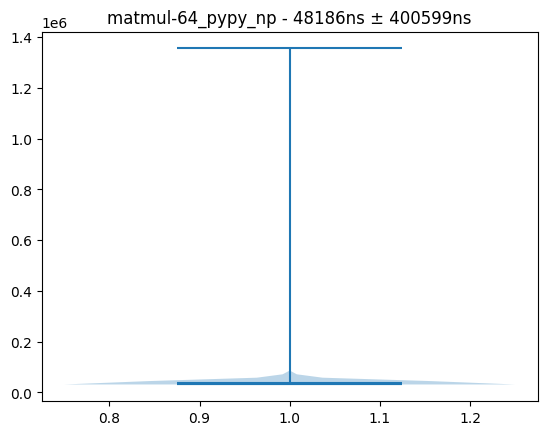

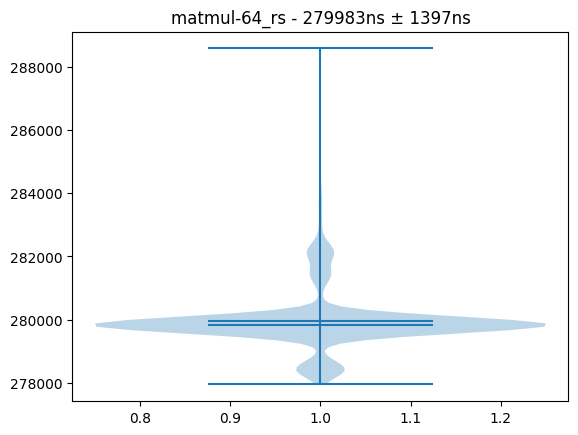

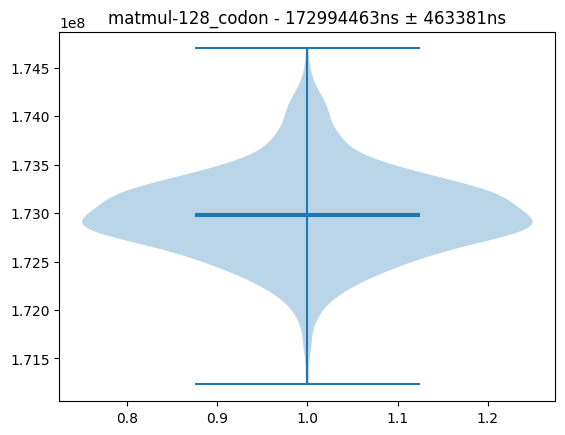

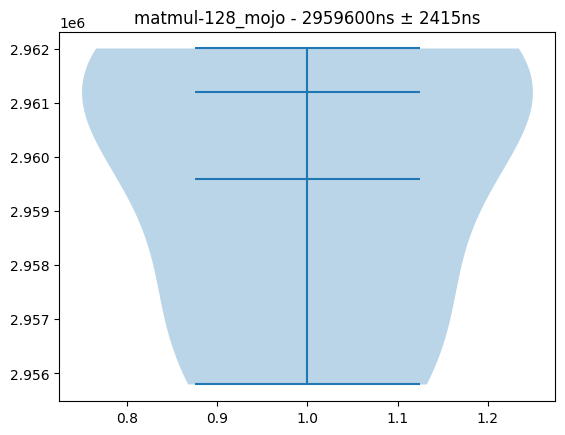

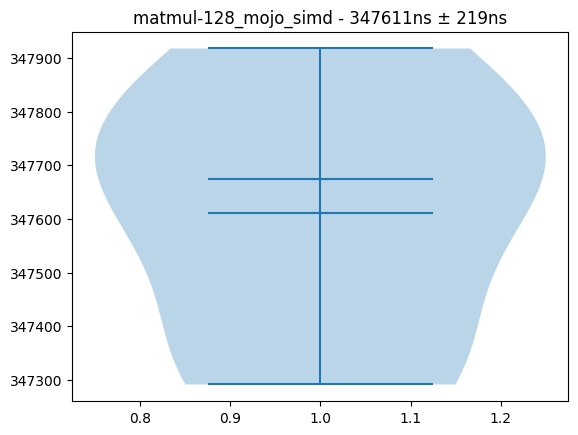

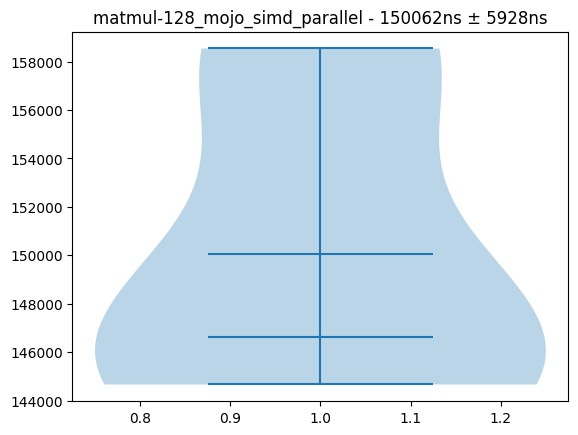

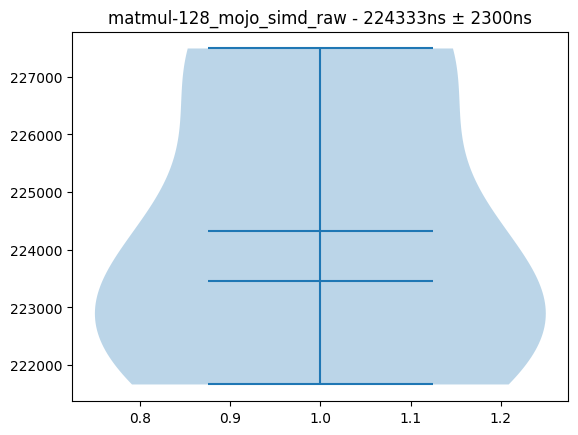

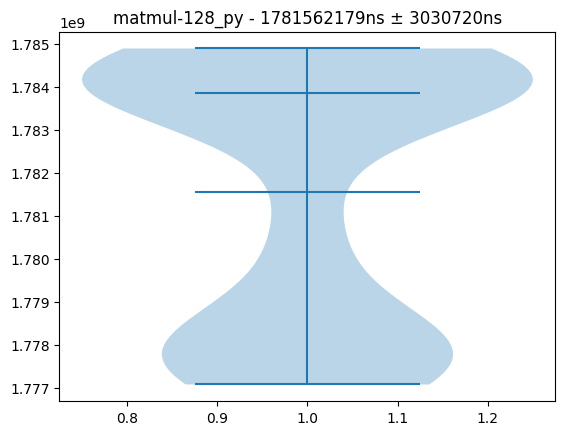

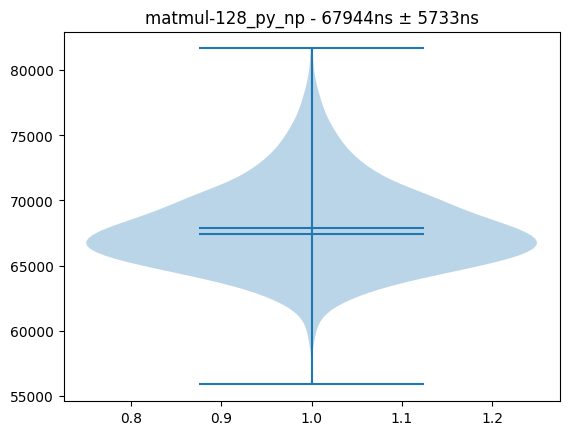

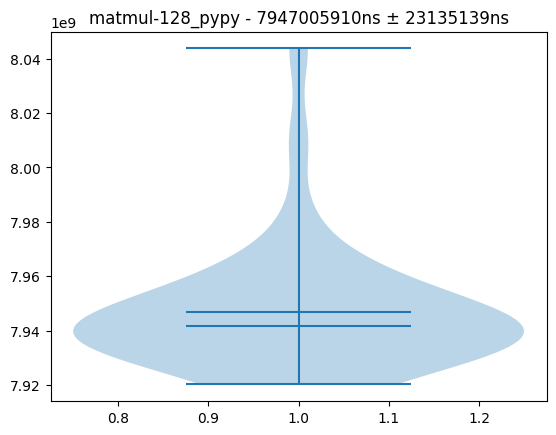

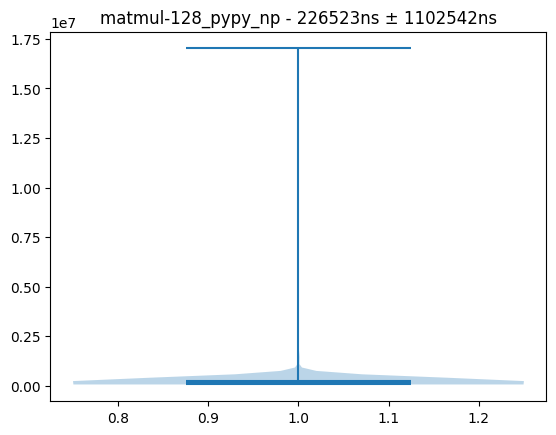

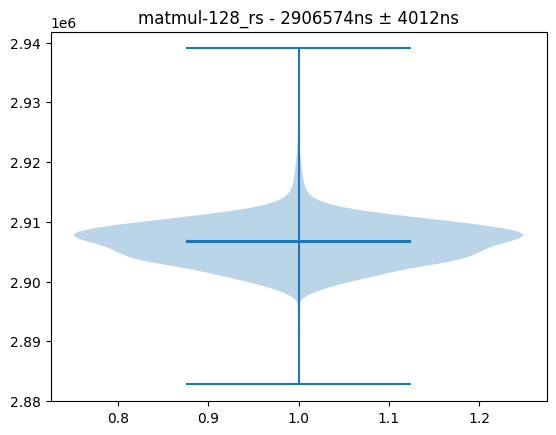

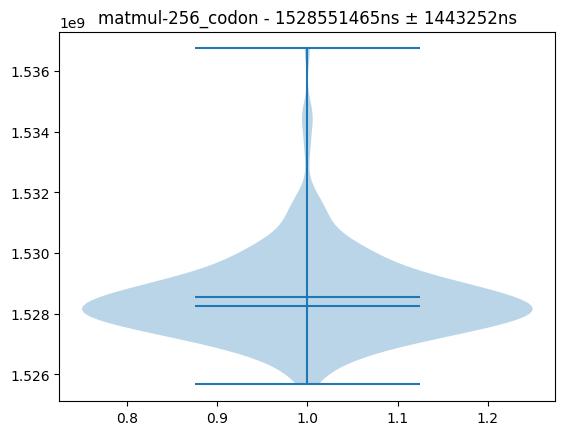

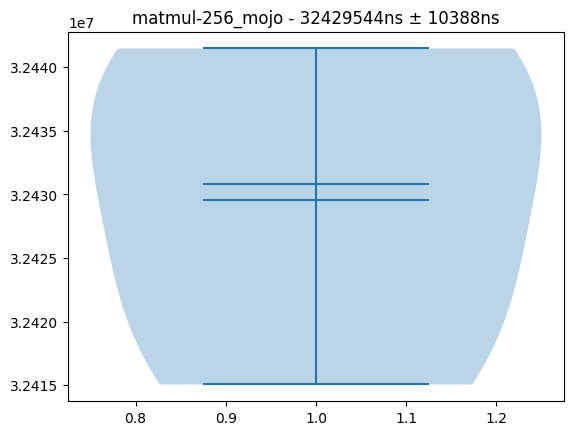

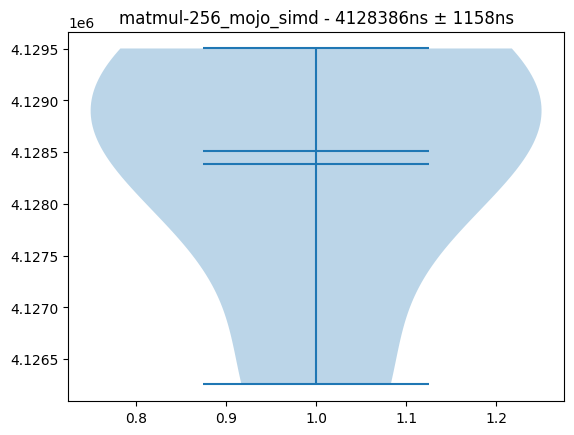

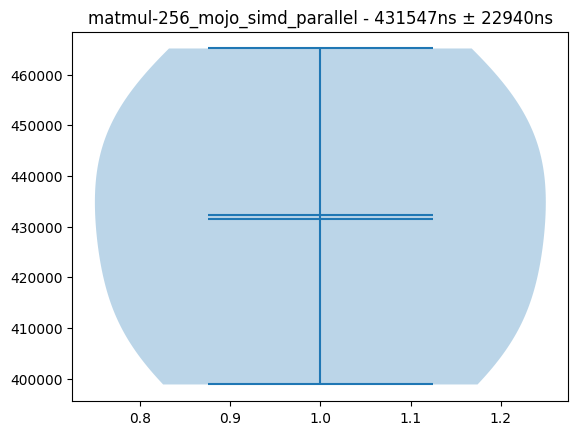

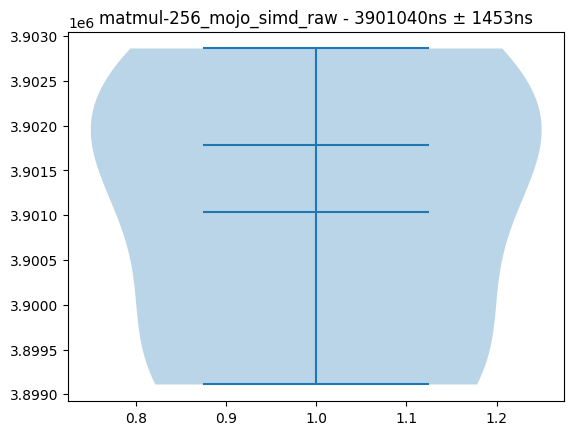

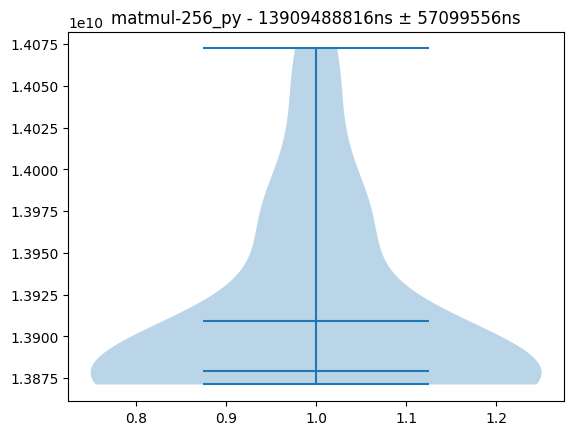

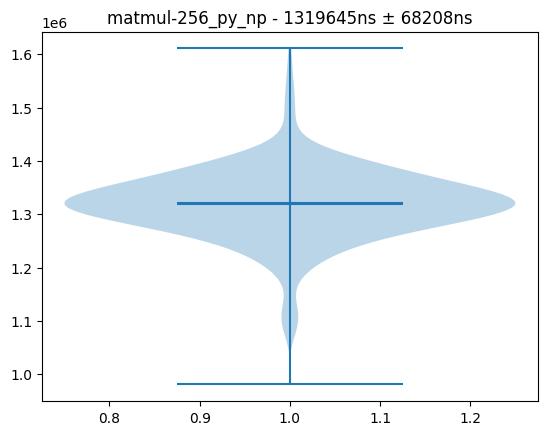

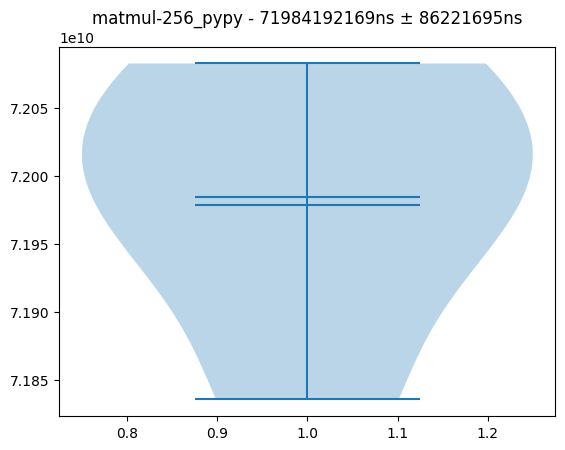

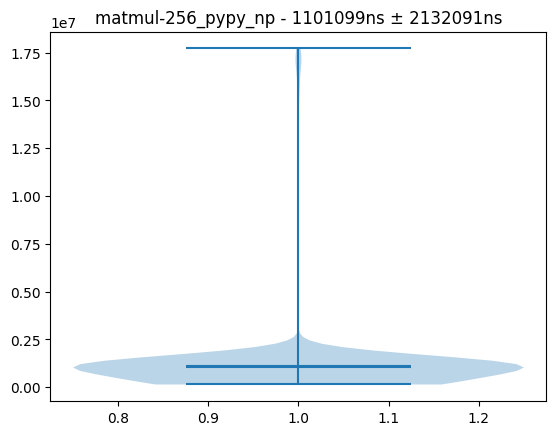

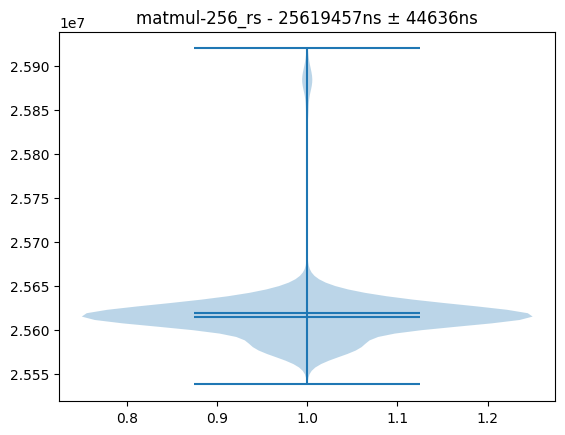

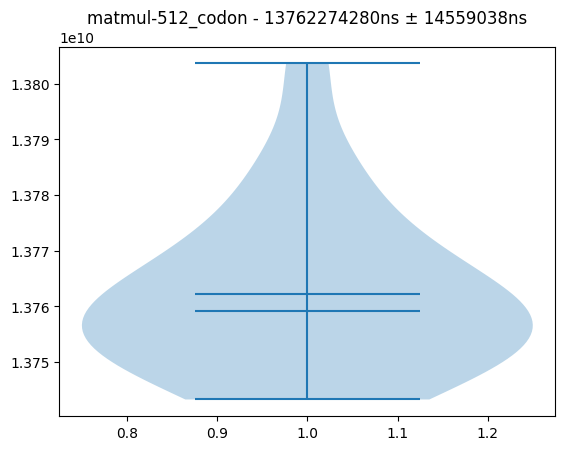

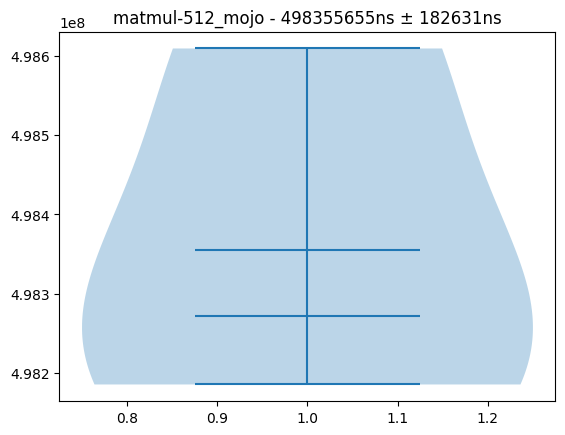

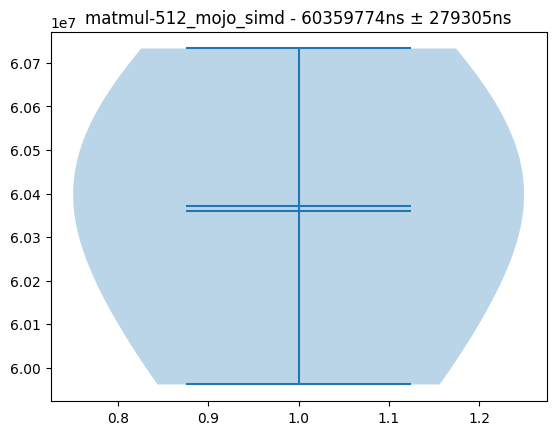

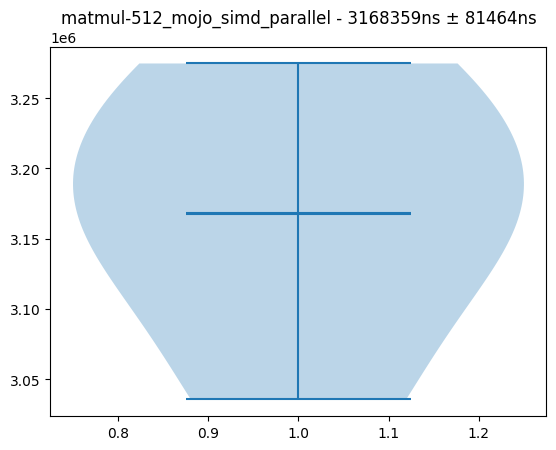

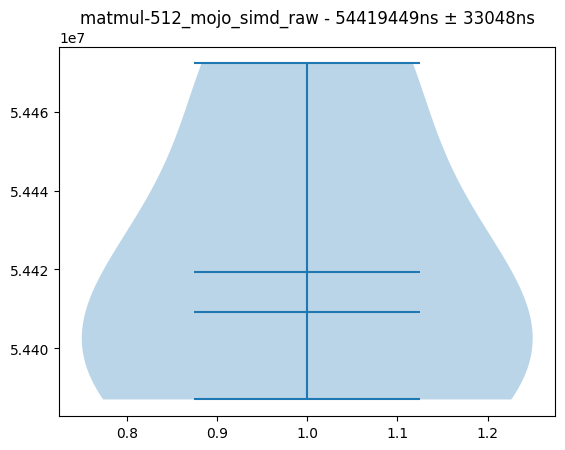

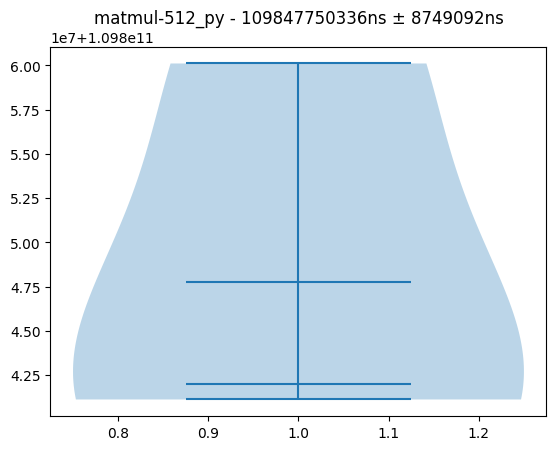

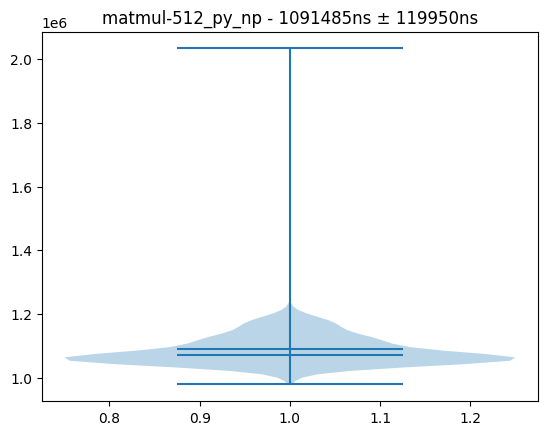

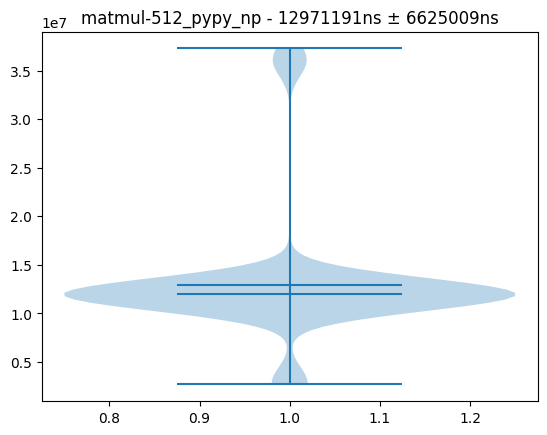

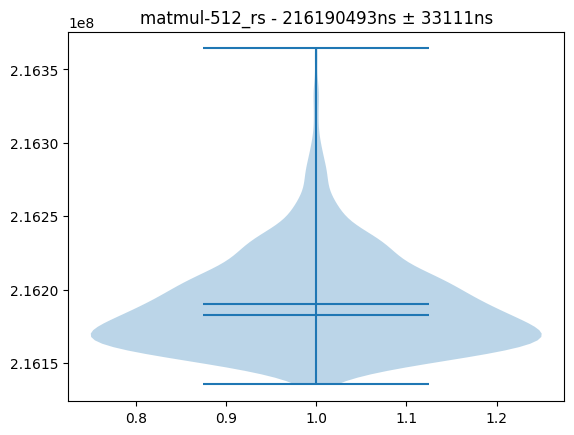

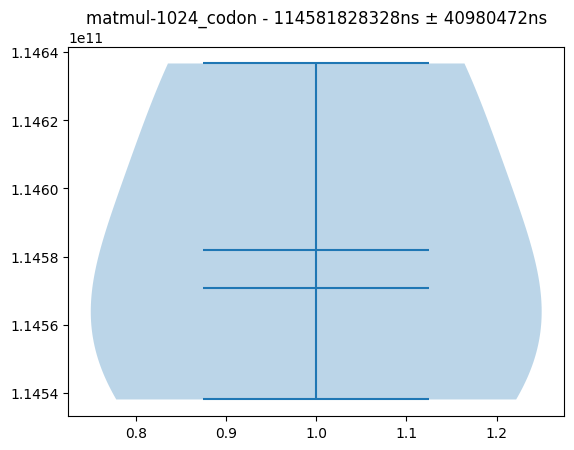

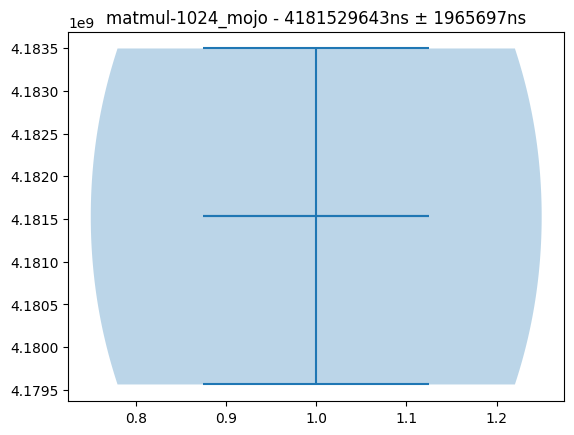

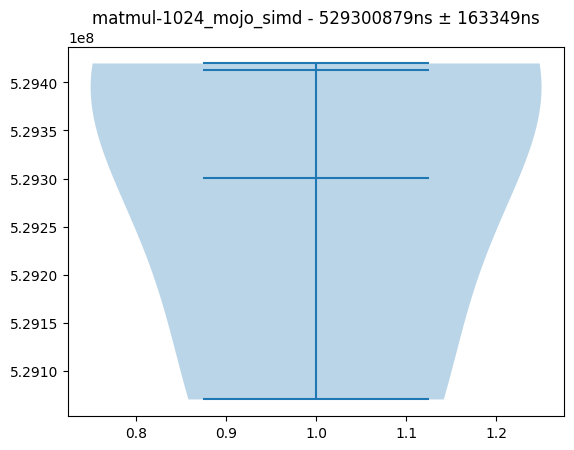

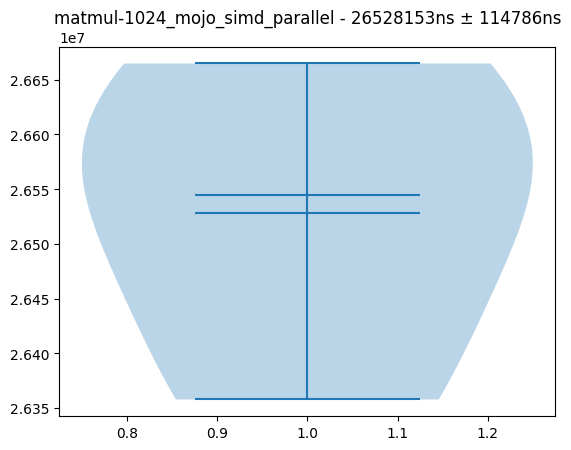

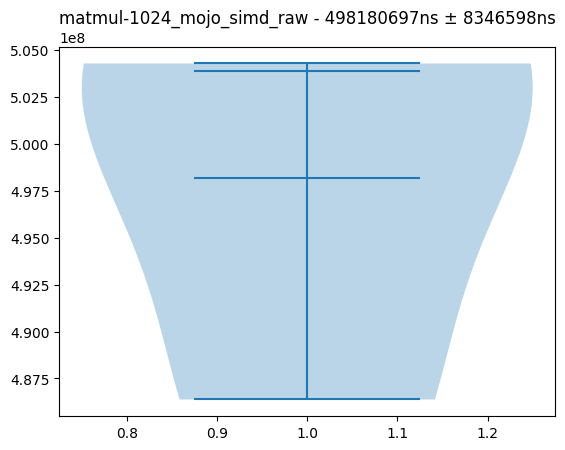

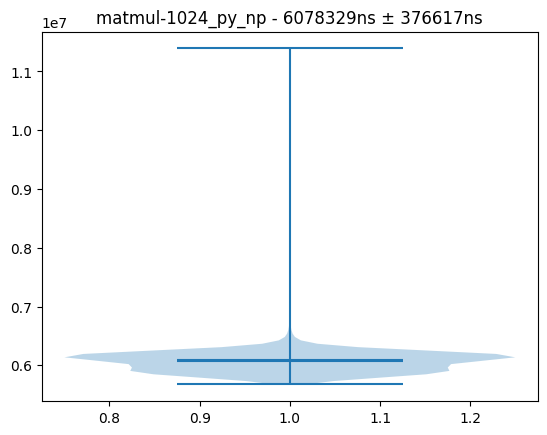

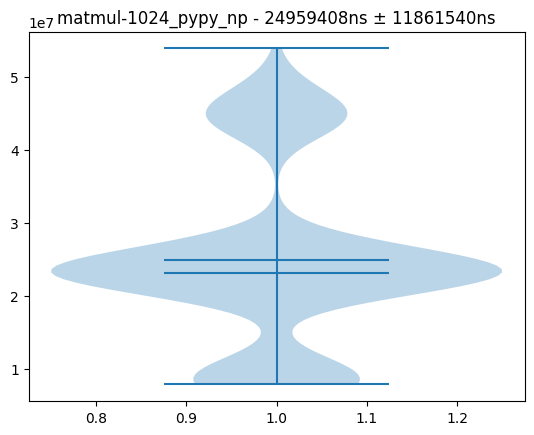

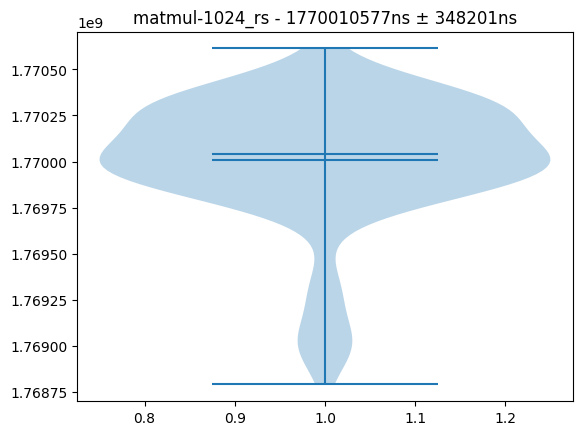

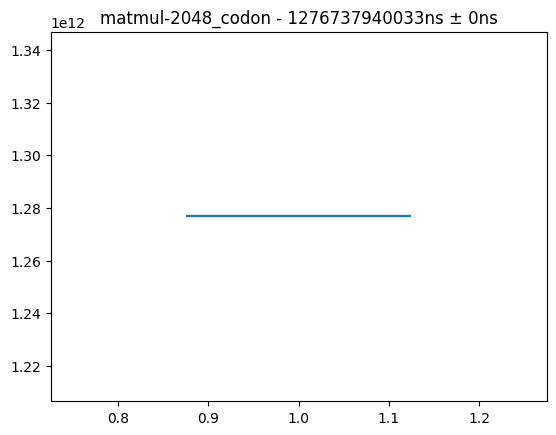

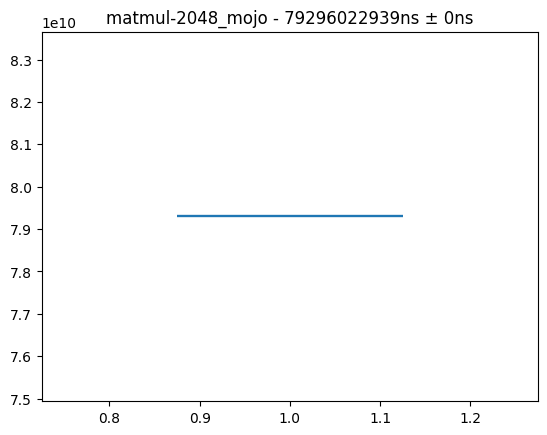

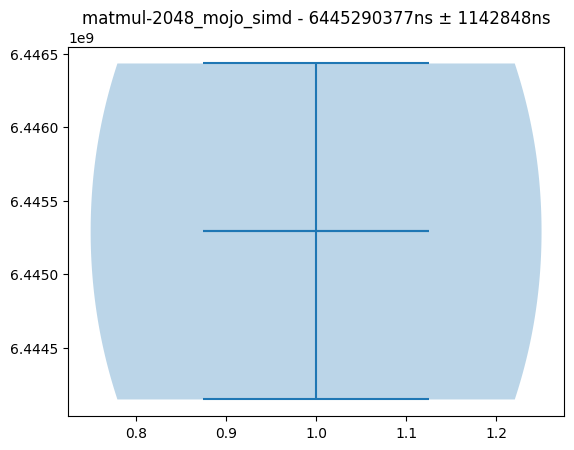

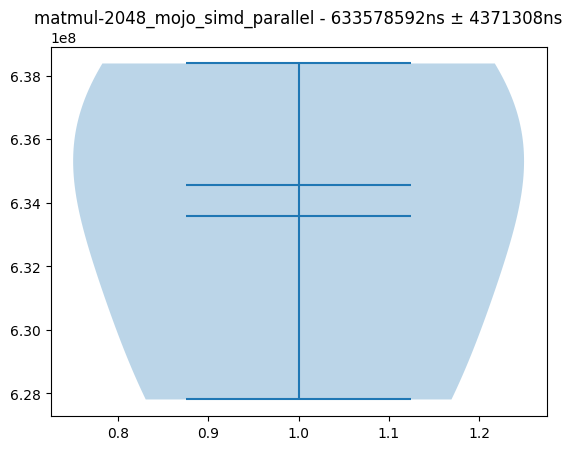

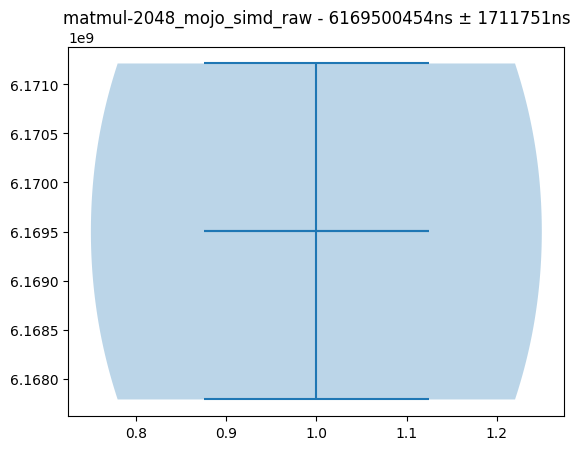

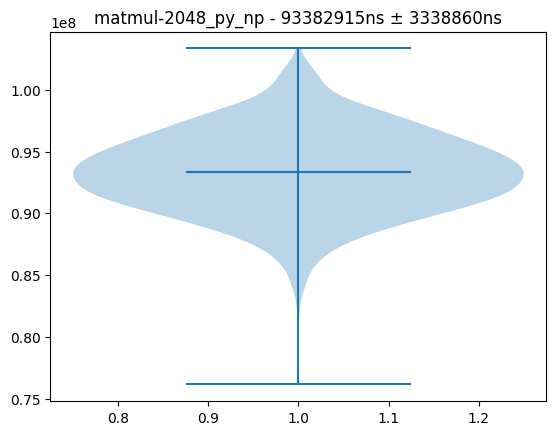

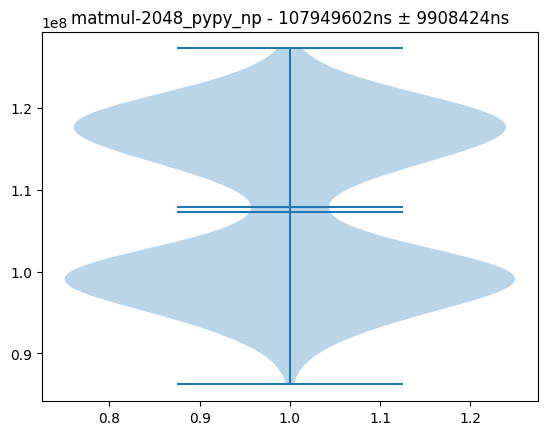

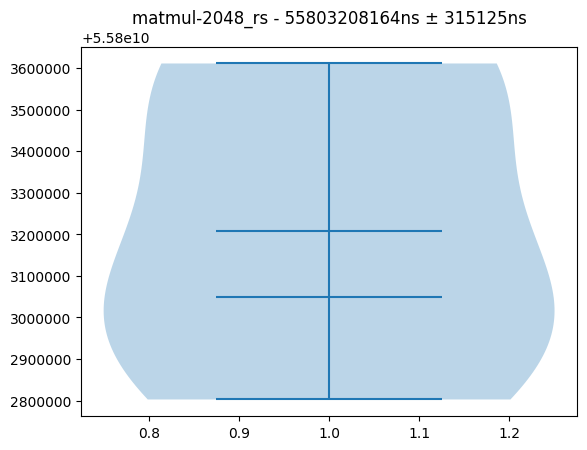

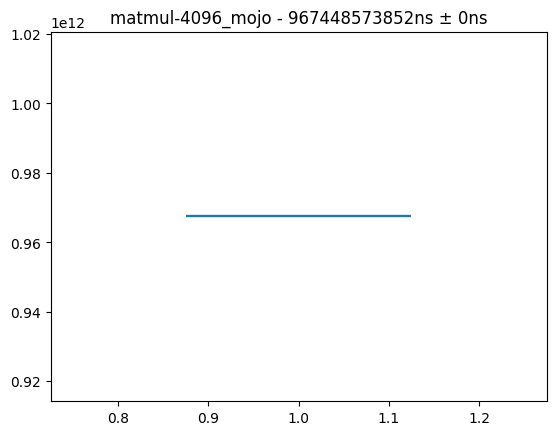

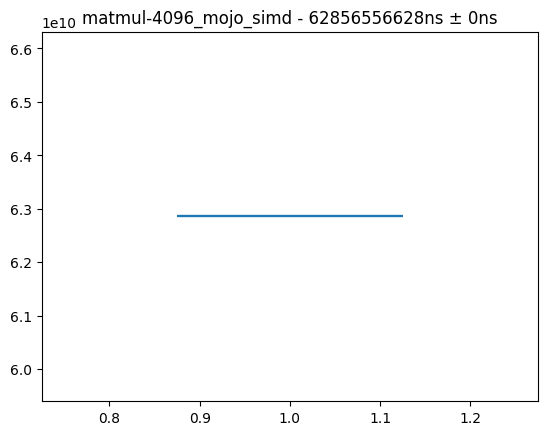

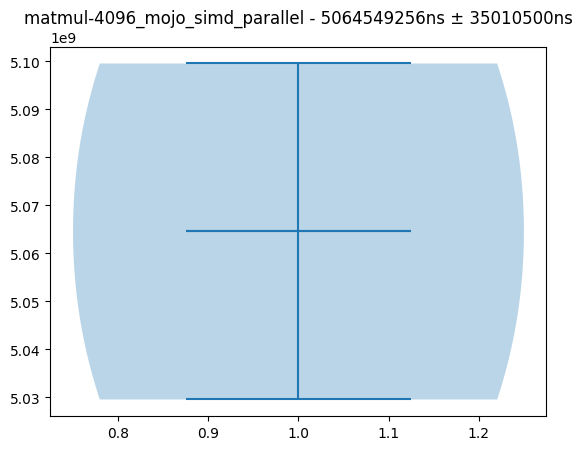

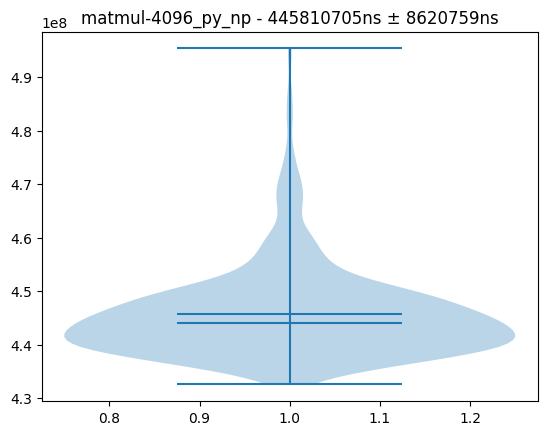

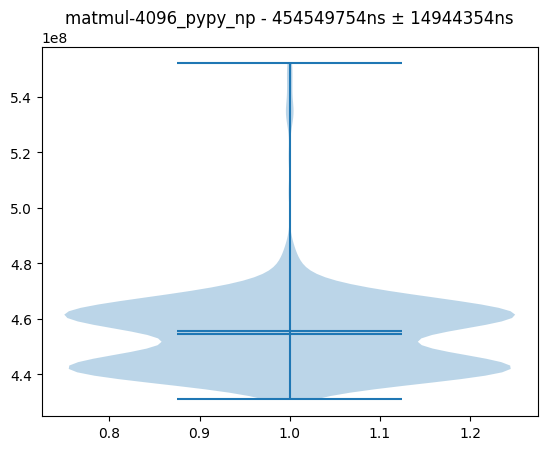

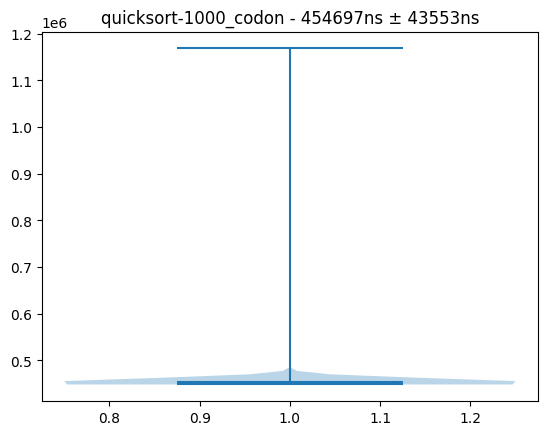

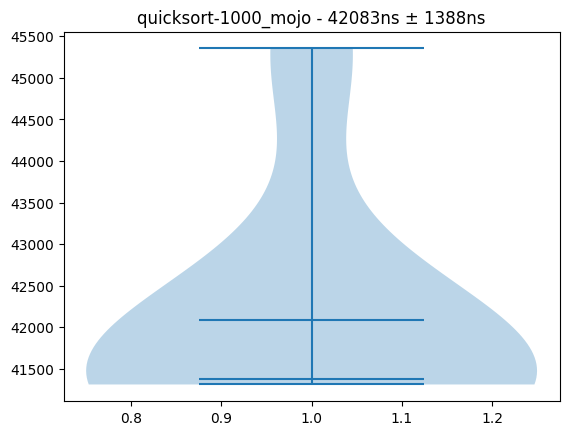

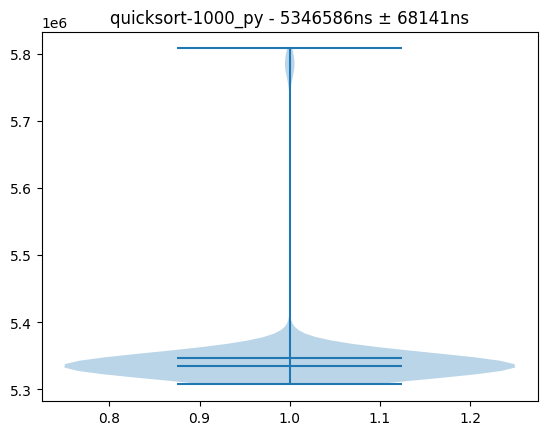

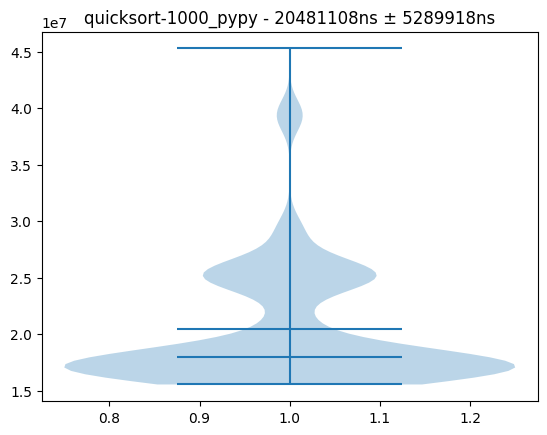

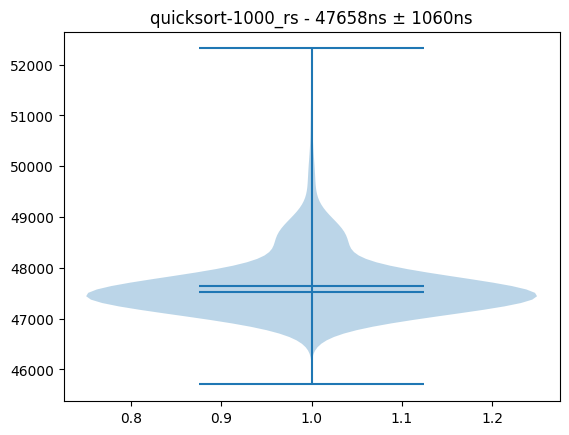

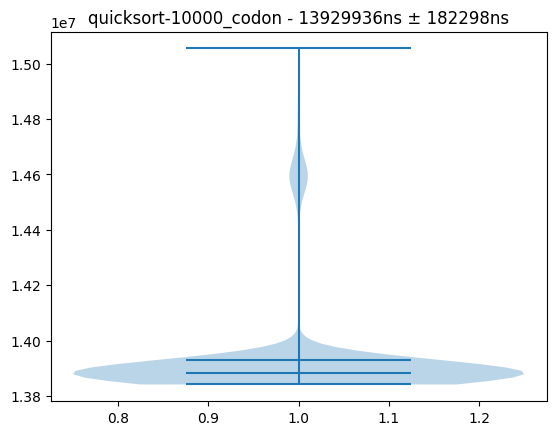

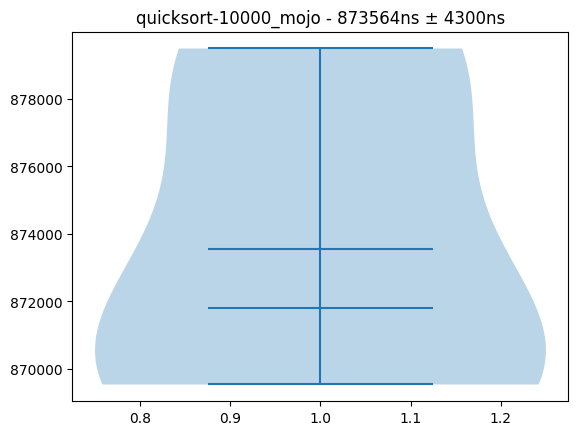

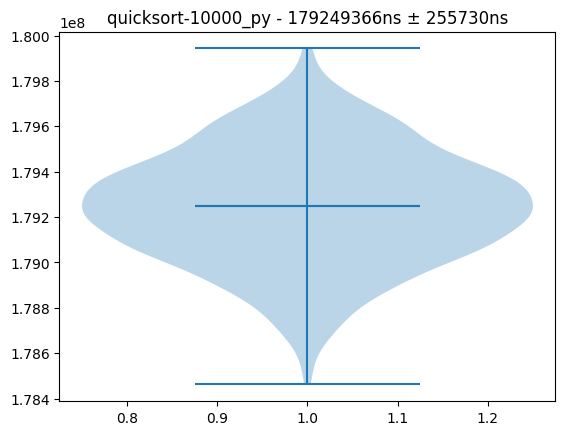

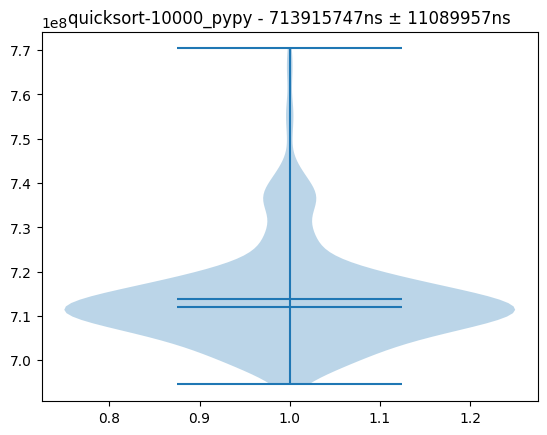

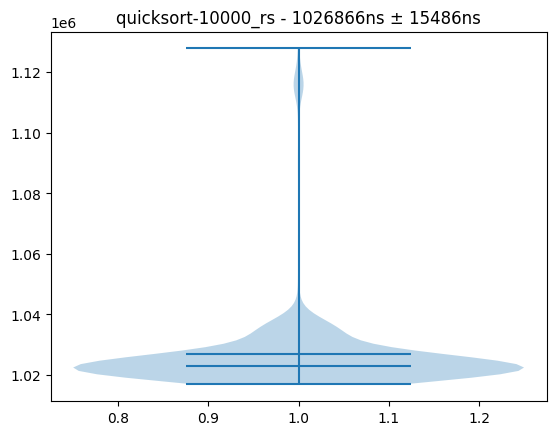

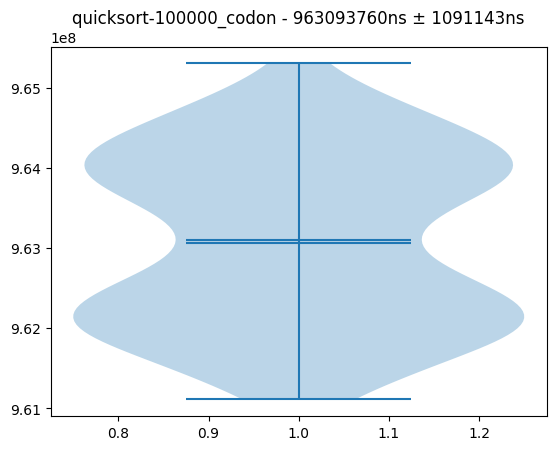

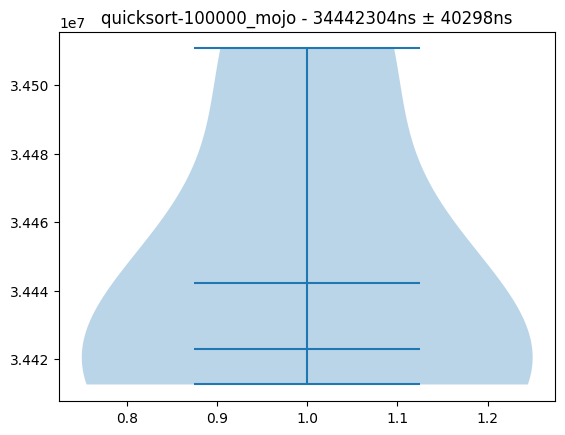

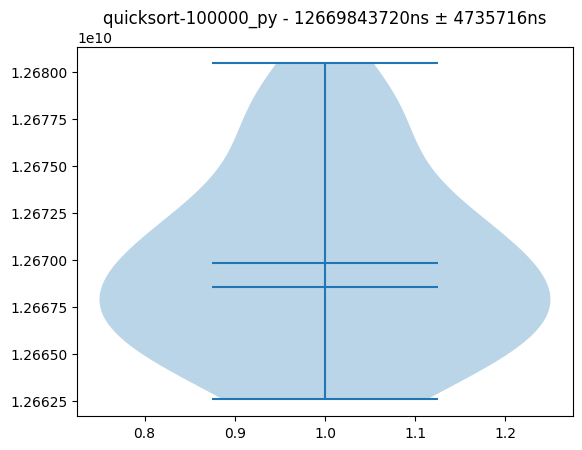

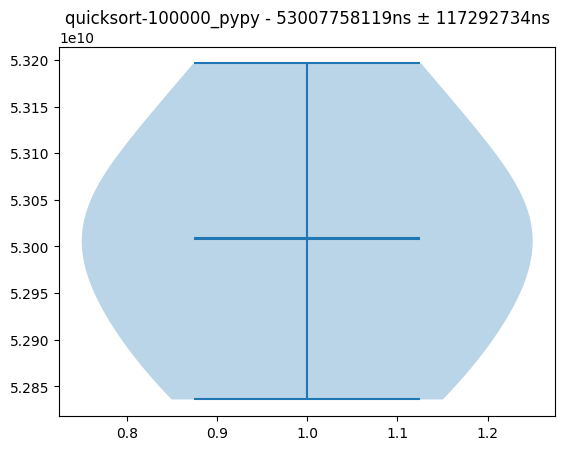

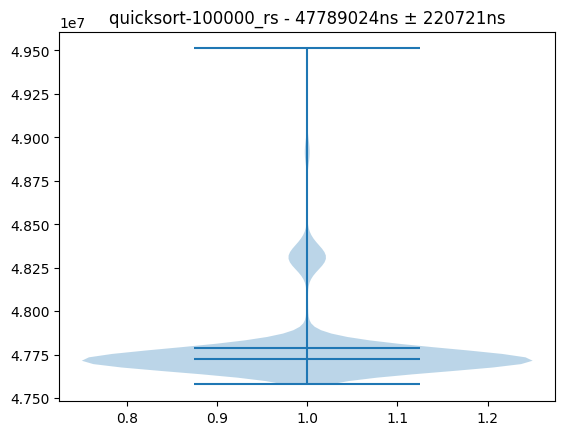

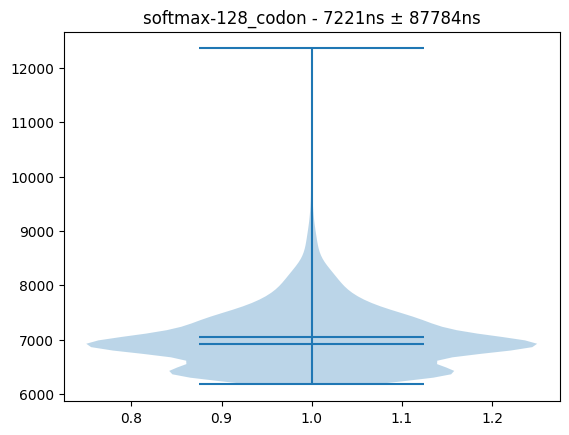

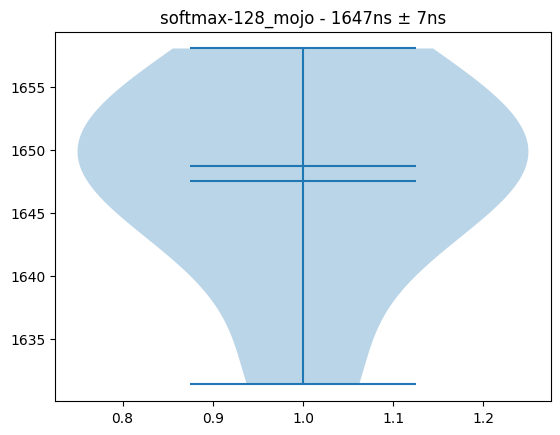

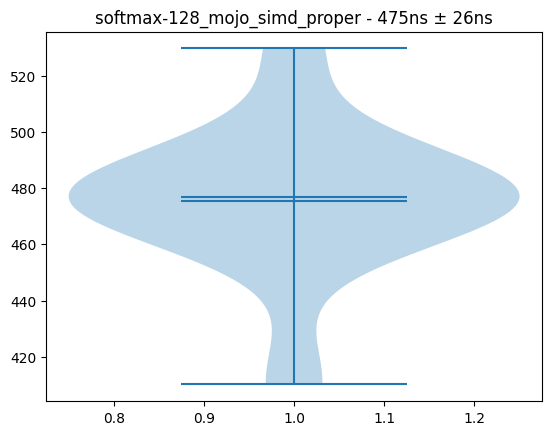

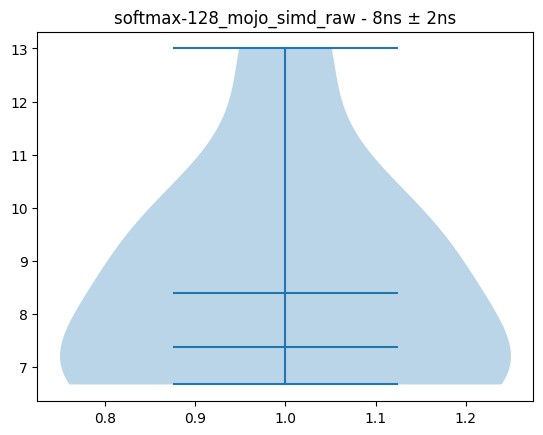

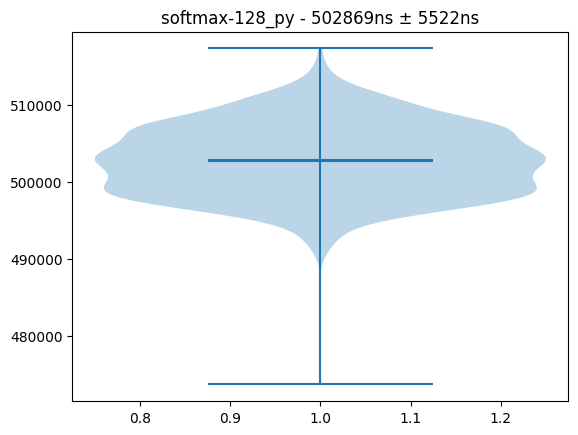

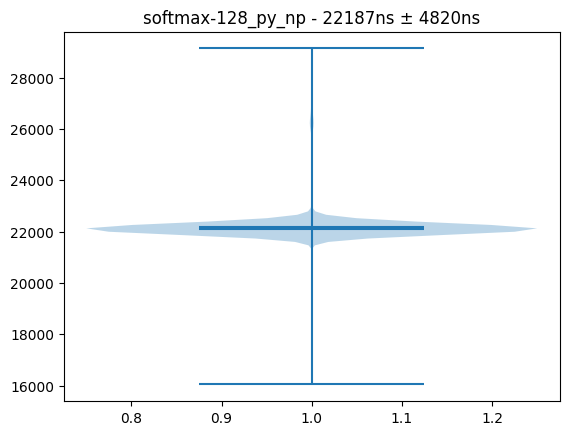

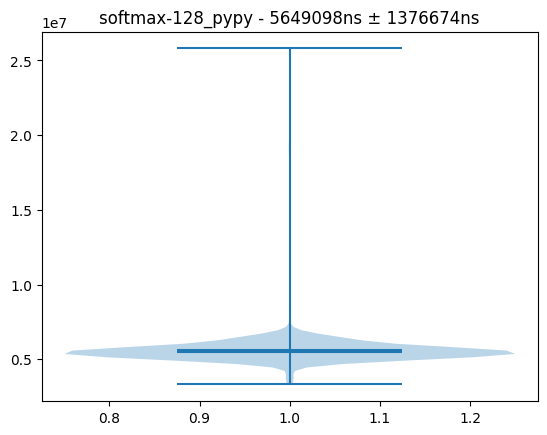

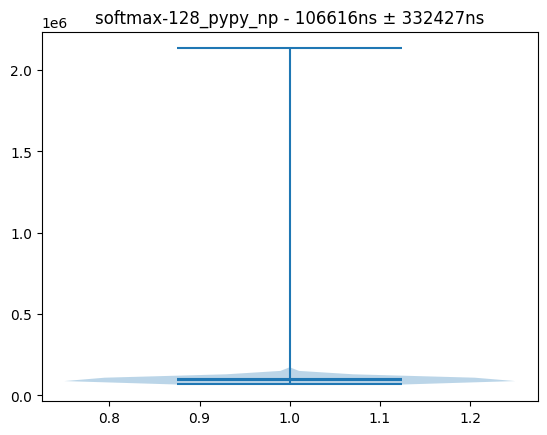

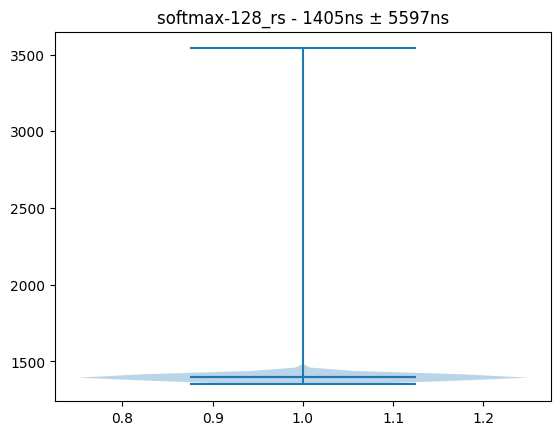

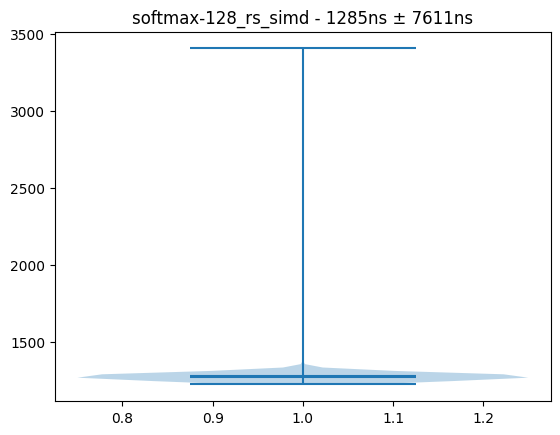

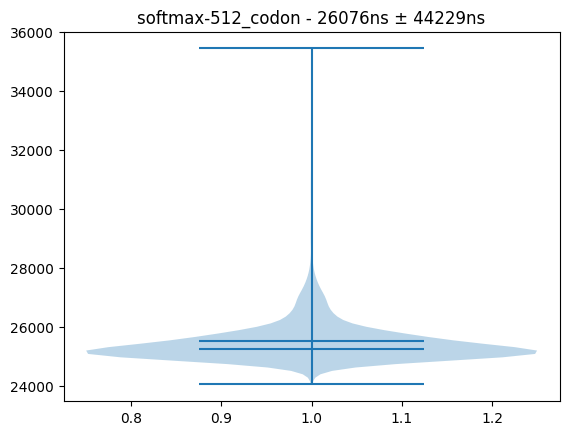

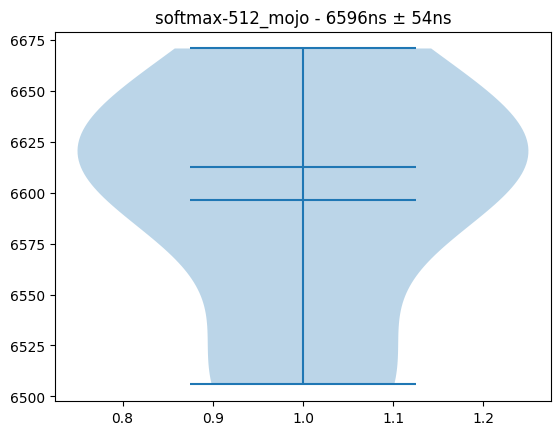

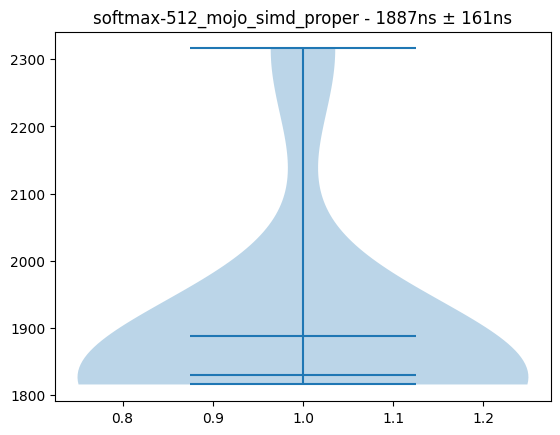

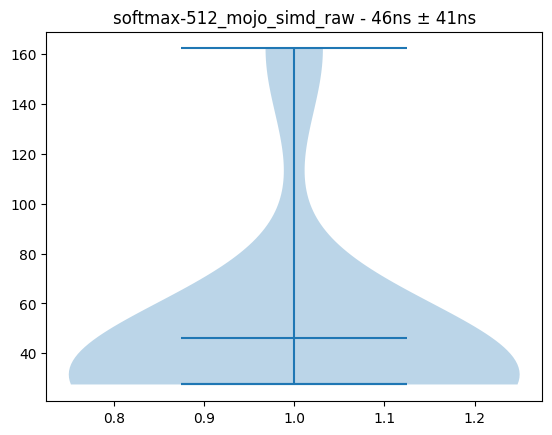

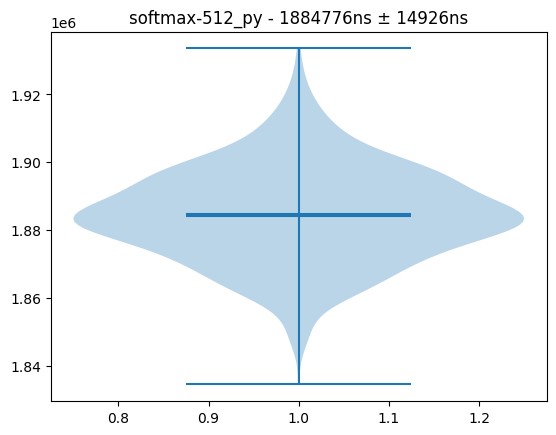

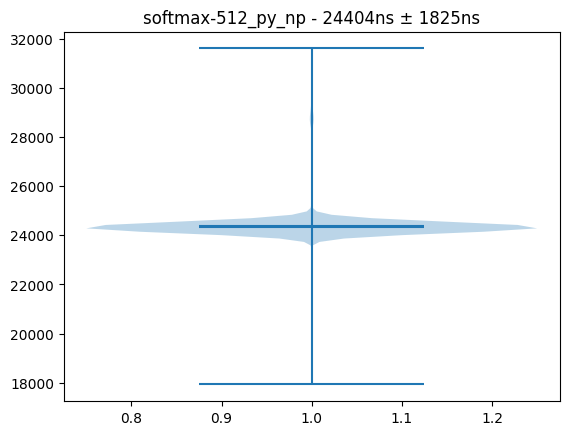

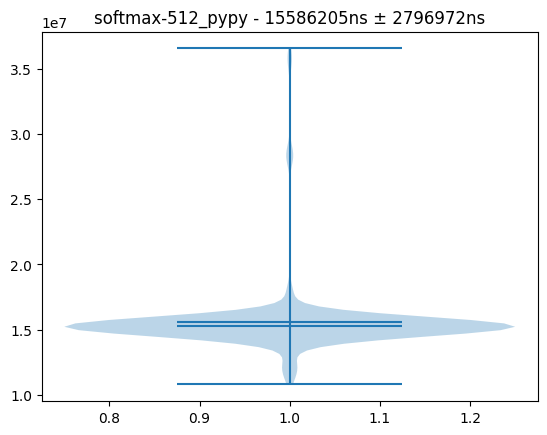

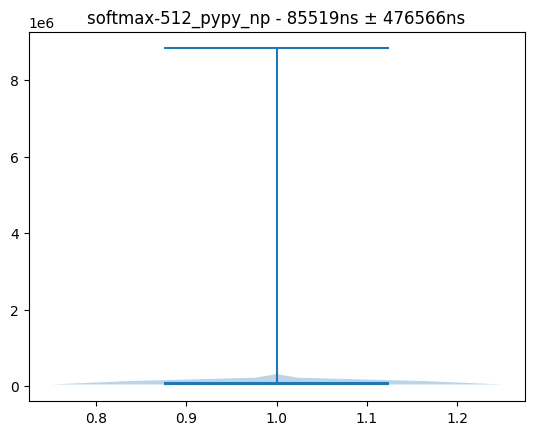

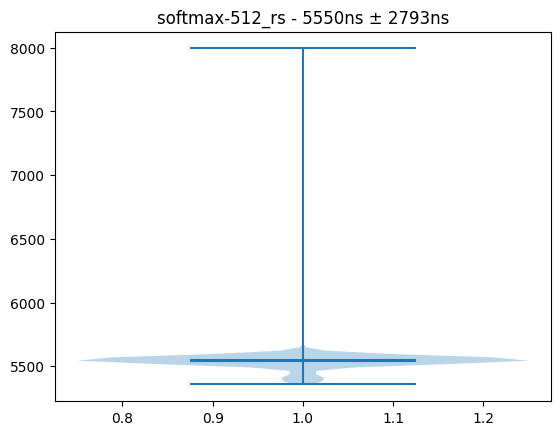

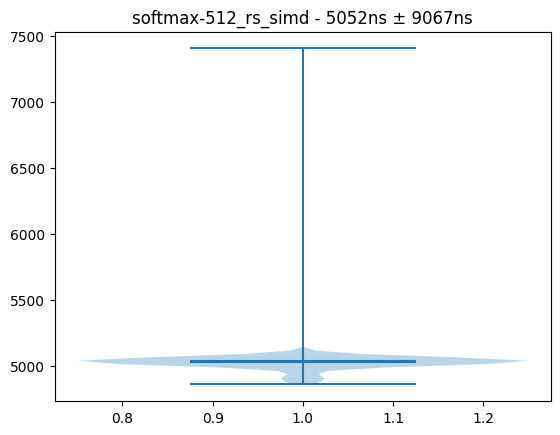

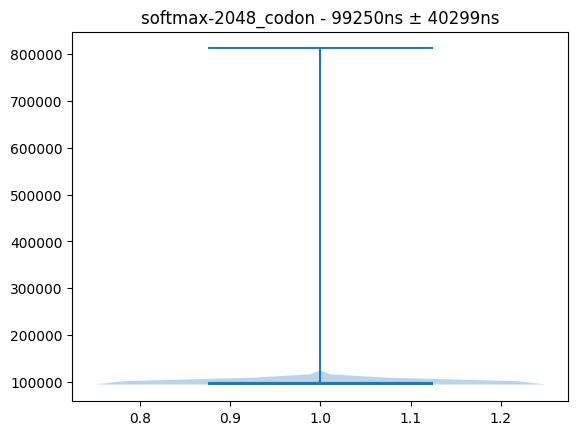

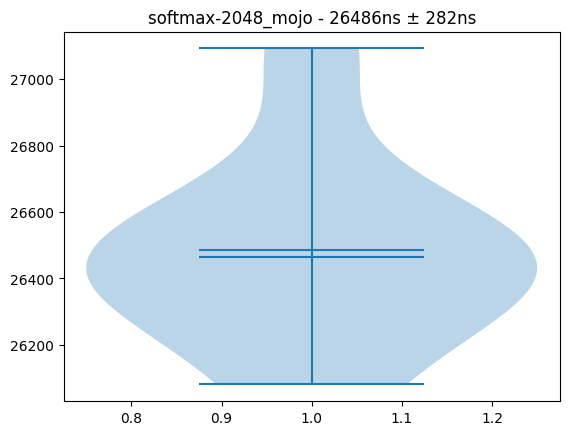

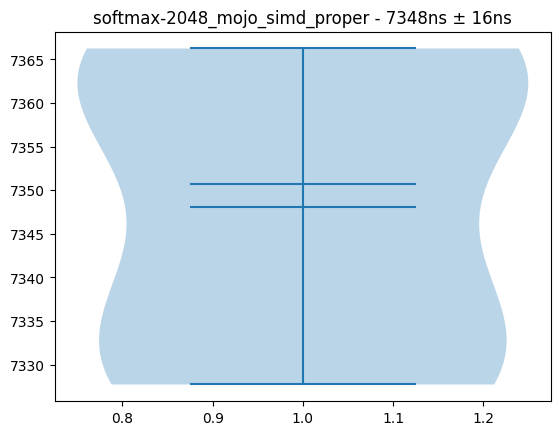

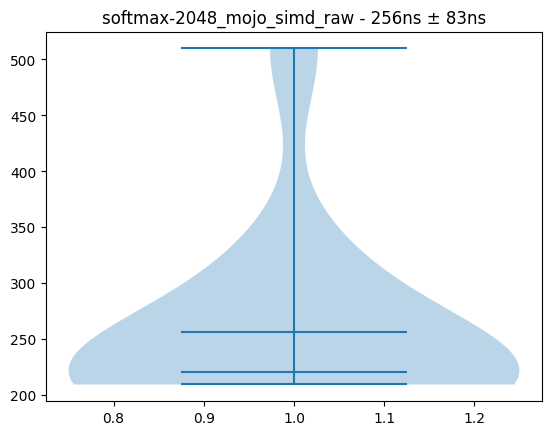

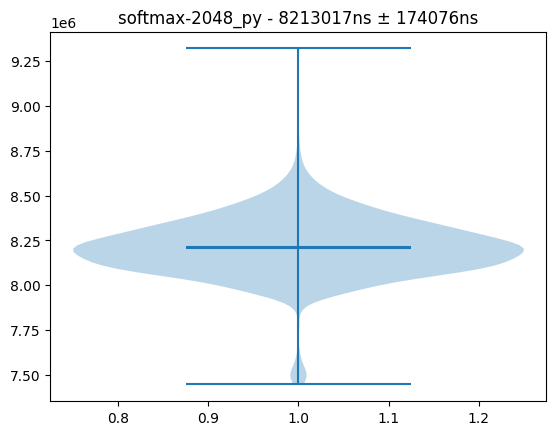

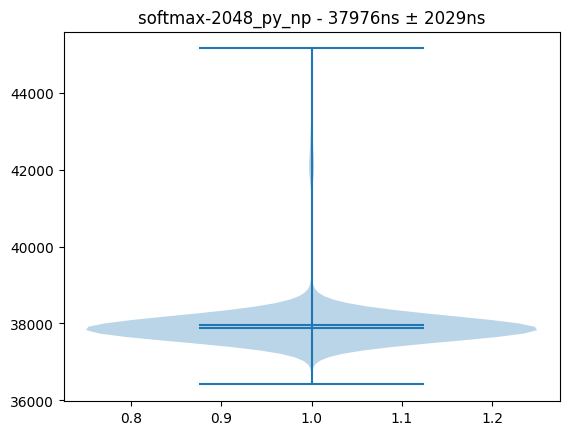

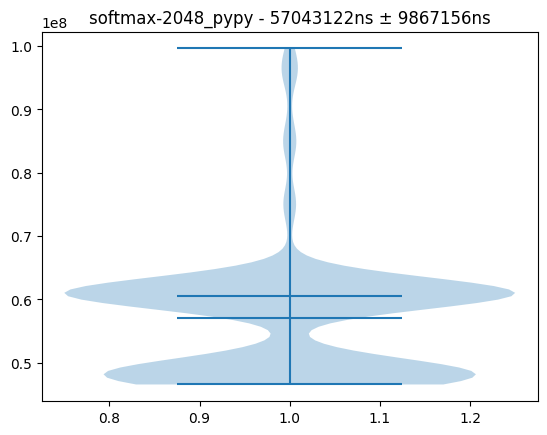

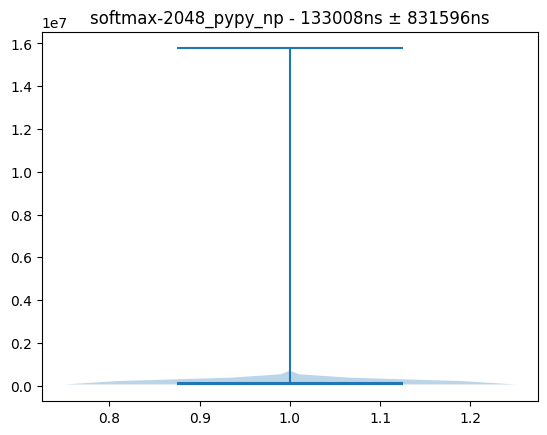

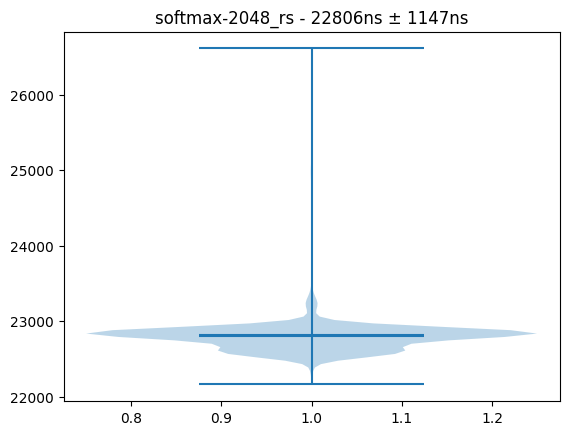

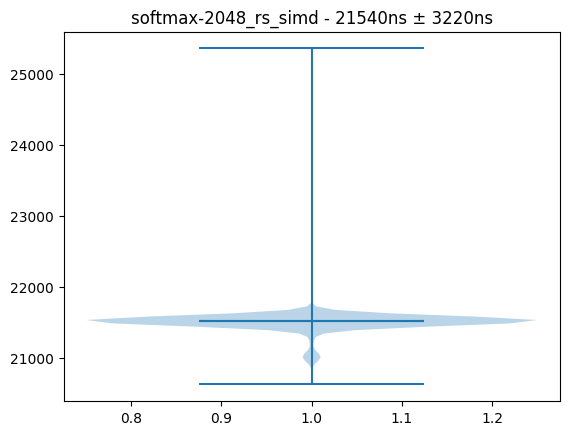

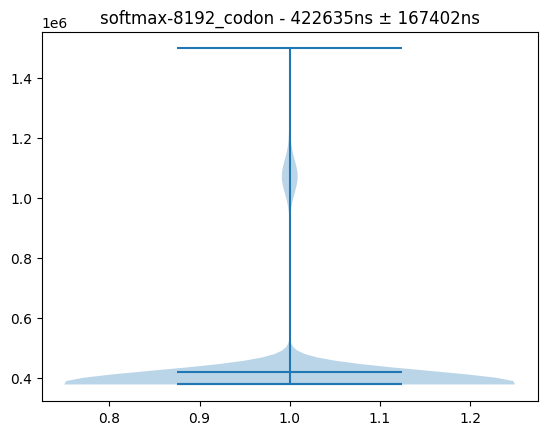

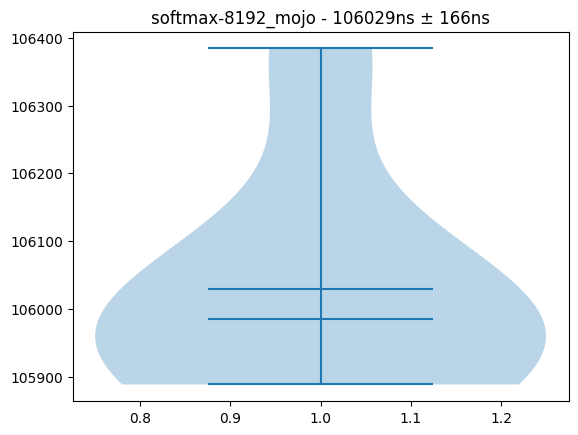

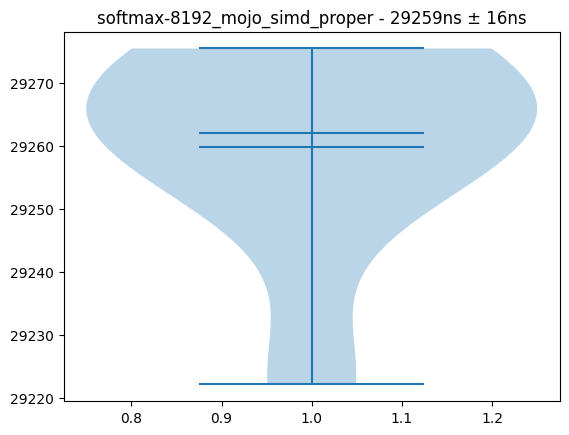

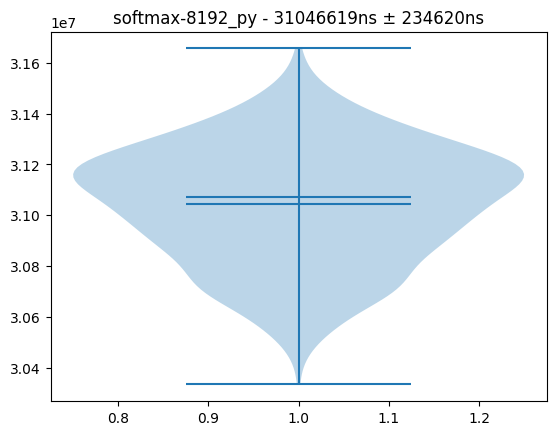

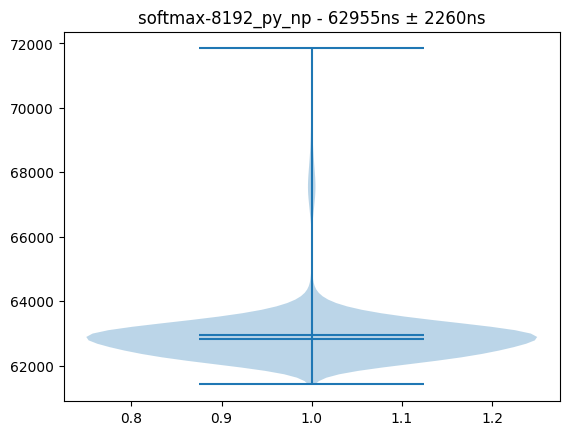

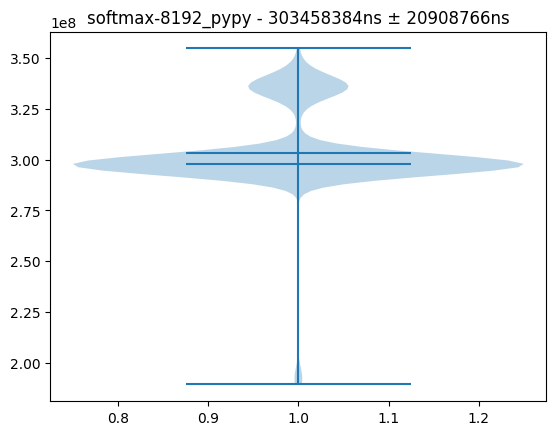

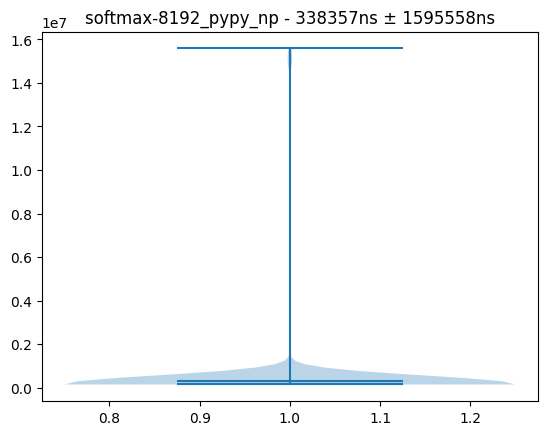

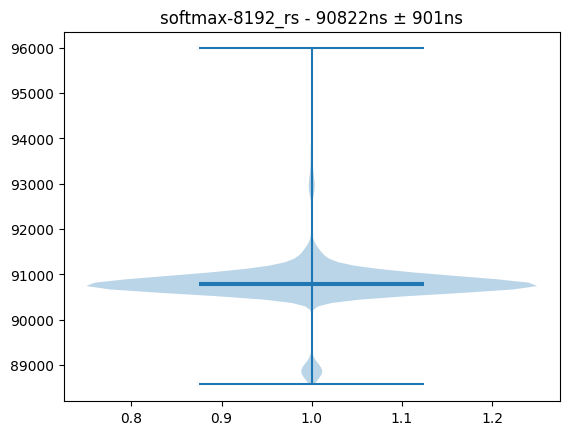

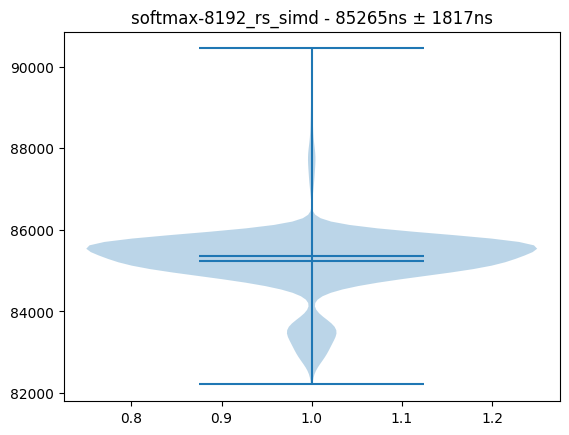

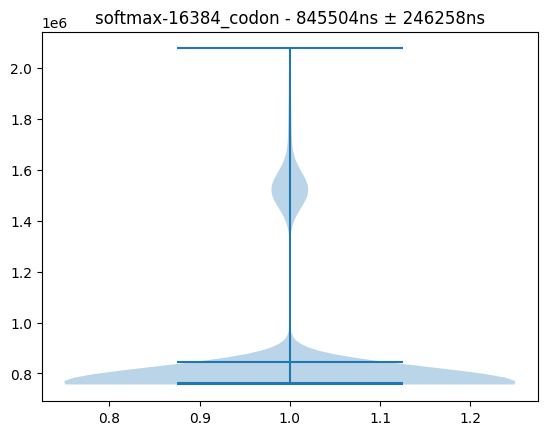

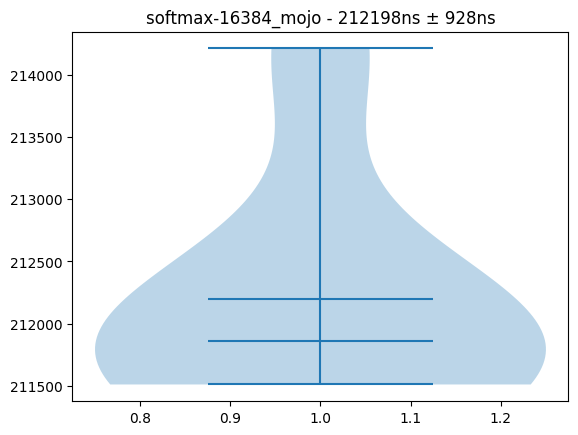

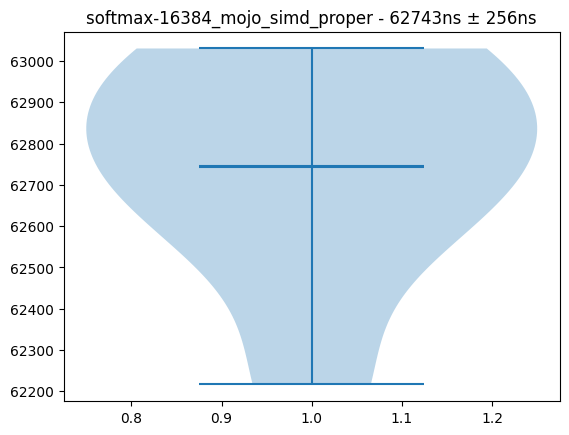

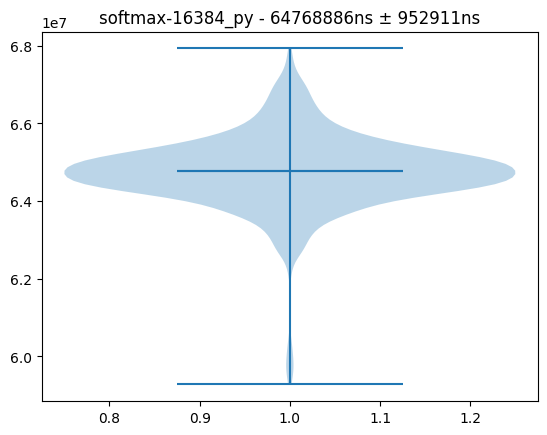

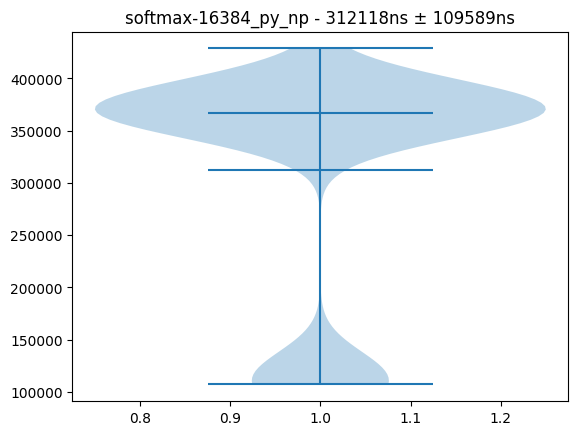

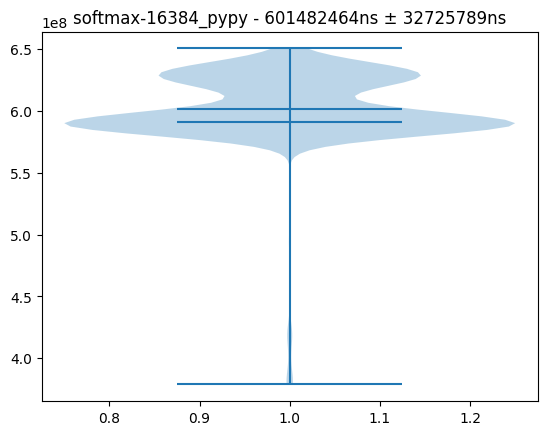

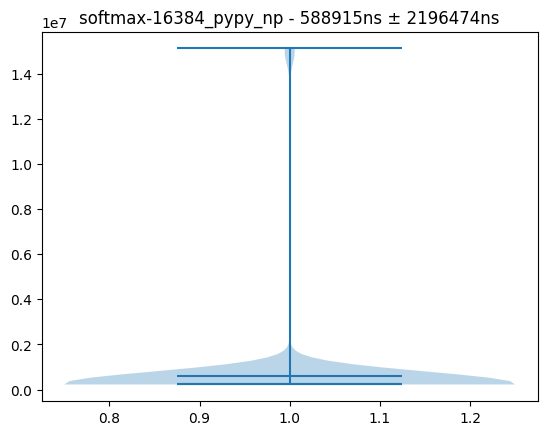

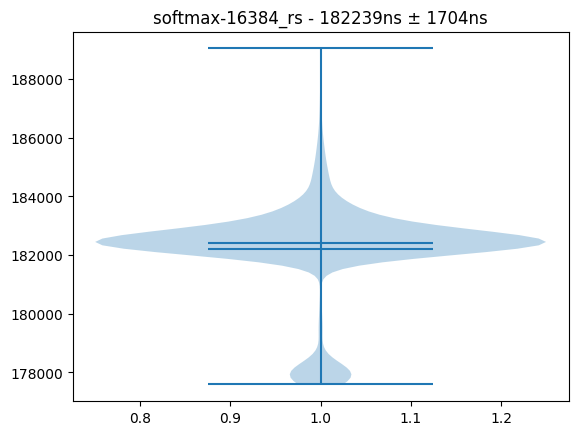

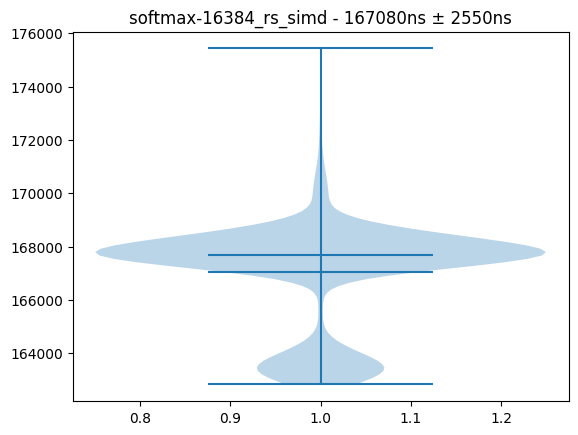

In [12]:
# draw a box plot for each algorithm+language impl
for b in benches:
    plt.figure()
    # plt.boxplot(b.samples)
    plt.violinplot(b.samples, showmeans=True, showmedians=True)
    plt.title(f"{b.ident} - {int(b.mean)}ns ± {int(b.std)}ns")
    plt.show()